# 「プチ」勉強会 20230805
* 今回は、今月の応用の課題「顧客に合せた保険提案をクラスター分析を用いて考えよう」に対するアプローチ。
* クラスタリングは、一度「クラスター分析で患者を分類しよう」で取り上げられていて、そこでは階層型のhierarcheyモデルが使用されていた。
* データ数が少ない場合はデンドログラムで可視化できる階層型が向いているという話だったが今回の2000というデータ数は多いのか少ないのか。どちらもやってみた。
* もうひとつの注目点は質的変数（genderもあるが特にprofession）に順序尺度がなく、代わりに要素数に差がつけられていること。この点の取り扱いがミソなんだろうと思う。
* また、非階層型クラスタリングの場合、可視化に用いる次元削減が、これが教師あり機械学習でも応用可能な可視化と特徴量作成手段であることが分かった。
* いずれにしてもいろいろ試してみるのは良いことだと思う。

## 今回取り組んでみたこと
1. ChatGPTくんに相談していろいろなモデルを紹介してもらい、全部試してみた。
```
   ・クラスタリングは階層型はhierarchyを使い、非階層型は代表的なモデルとされるK-MeansとDBSCAN、それとGMM(GaussianMixture)を使用した。
   ・次元縮減はPCAのほか、さまざまな多様体モデル（MDS,LocallyLinearEmbedding,SpectralEmbedding,Isomap,t-SNE,UMAP）を一通り試した。
   ・また、正解との比較を行わない評価モデルを3つ(silhouette_score,davies_bouldin_score,calinski_harabasz_score)使用した。
   ・これらの全ての組み合わせと各々の評価をグラフとデータフレームに表示するようコーディングしてみた。
   ・なお、各モデルのなかにはパラメータ依存度の高いものも少なくないため、別途試行錯誤して設定を行っている。
   ・なにより、次元縮約が特徴量生成の効果があるということなので、今後の教師あり学習への応用可能性が期待されるところ。
```
2. 手順としてはまずEDAから入り、クラスタリング結果を纏めて解釈を試みた形。
```
   ・EDAの結果、明らかに不自然な内容と分かったのでそのことを照会したが、意図的とのことなのでそのまま進めた。
   ・冒頭にも書いたが、EDAおよびクラスタリングの試行錯誤の結果、今回の狙いのひとつが「順序尺度を持たない質的変数のエンコーディング方法」であると分かった。
   ・全般に一様な分布になっているなか、質的変数の数に意図的と思われる偏りがみられ、これをカウントエンコーディングで拾うときっちり4分類されると分かった。
   ・標準化しない、あるいは質的変数のエンコーディングをOne-hotで行うなどすると次元縮約がうまく機能せず、各グラフがモデル特有の値に集まる様子が見て取れた。
   ・正直なところ、「解釈」に関しては良くわからなかったが、元の分布が非現実的で意図的な感じなのでやむを得ないことと思う。
```

# 顧客に合わせた保険提案をクラスター分析を用いて考えよう

In [28]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# クラスタリング機械学習モデル（階層型）
import scipy.cluster.hierarchy as sch                     # 分割型階層的クラスタリング
                                                          # ・データポイントをネストしたクラスターに編成
                                                          # ・リンケージ行列を計算するlinkage関数、デンドログラムを描画するdendrogram関数などを提供
from scipy.spatial.distance import pdist                  # ペアワイズ距離計算
                                                          # ・linkage関数の入力として使用

# クラスタリング機械学習モデル（非階層型）
from sklearn.cluster import KMeans                        # K-Means
                                                          # ・データをk個のクラスタに分割
                                                          # ・クラスタ内の分散が最小になるようにデータポイントをクラスタに割り当て（ハードクラスタリング）
                                                          # ・円形（または超球形）のクラスタを想定するので、他の形状のクラスタには当て嵌まりにくい
from sklearn.cluster import DBSCAN                        # DBSCAN（Density-Based Spatial Clustering of Applications with Noize）
                                                          # ・クラスタは密度に基づいて定義し、密集している領域をクラスタと認識する（ハードクラスタリング）
                                                          # ・クラスタの数の事前指定は不要、且つ、クラスタは任意の形状を持つことが可能
                                                          # ・ノイズとして扱われるデータポイントを自動的に識別
from sklearn.mixture import GaussianMixture               # ガウス混合モデル(Gaussian Mixture Models:GMM)
                                                          # ・最尤推定によりデータポイントが各クラスタに属する確率を提供する（ソフトクラスタリング）
                                                          # ・各クラスタがガウス分布（正規分布）に従うと仮定するため取り得るクラスタ形状は幅広い
                                                          # ・クラスタ数の指定が必要なほか結果が初期化に大きく依存する

# 次元縮約機械学習モデル（PCA、多様体manifolder）
from sklearn.decomposition import PCA                     # 主成分分析（PCA）
                                                          # ・データの各成分間の相関を利用して元の変数を主成分に変換する（主成分は元の変数の線形結合）
                                                          # ・主成分はデータの分散を最大化する方向を表すため、最初の数個の主成分だけを取り出すことで次元を削減できる
                                                          # ・特徴抽出の一形態と見做すこともできる
                                                          # ・線形変換なので非線形の関係性を捉えることはできない
                                                          # ・分散が最大の方向を捉えることが必ずしもデータ構造やパターンを表現するとは限らない
                                                          # ・スケーリングに敏感なので標準化を要する
from sklearn.manifold import MDS                          # MDS(Multidimensional Scaling)
                                                          # ・観測された類似度または距離のセットから低次元空間内の点の位置を推定する
                                                          # ・多次元尺度法による推定は元の高次元データの距離構造を保持するよう試みるが完全には達成されない
from sklearn.manifold import LocallyLinearEmbedding       # Locally Linear Embedding（LLE）
                                                          # データが存在する多次元空間の局所的な特性を捉えそれを低次元空間に保持する
                                                          # Swiss rollなどの特定のデータ構造に対して非常に効果的
from sklearn.manifold import SpectralEmbedding            # Spectral Embedding(Laplacian Eigenmaps)
                                                          # ・データ点間の類似度から低次元空間への埋め込みを計算する
                                                          # ・グラフのスペクトル（ラプラシアン行列の固有値と固有ベクトル）に基づく縮約手法
from sklearn.manifold import Isomap                       # Isomap
                                                          # ・Geodesic（または曲面上の最短）距離を保持することで、非線形データの次元を縮約する
from sklearn.manifold import TSNE                         # t-SNE(t-Distributed Stochastic Neighbor Embedding)
                                                          # ・高次元空間での類似度と低次元空間での類似度を一致させることで高次元データを低次元空間へ埋め込む
                                                          # ・ランダム性を持つほか、クラスタのサイズや密度を正確に反映しない場合がある
import umap                                               # UMAP
                                                          # 計算コストが低く大規模なデータセットに対して高速に動作する
                                                          # t-SNEと比較して、データの局所的な構造だけでなく全体の構造もより良く保存する


# クラスタリング評価モデル
from sklearn.metrics import silhouette_score              # シルエットスコア（Silhuette Score）
                                                          # ・各サンプルが属するクラスタ内の他のサンプルとの距離（結束性）および最も近い他のクラスタとの距離（分離性）を評価
                                                          # ・-1から1の範囲を取り値が大きいほどクラスタリングが良好と判断
from sklearn.metrics import davies_bouldin_score          # Davies-Bouldin Indes（DBI）
                                                          # ・クラスタ間の平均距離とクラスタ内の散布を比較して品質を評価
                                                          # ・値が小さいほどクラスタリングが良好と判断
from sklearn.metrics import calinski_harabasz_score       # Calinski-Harabasz Index
                                                          # ・クラスタ内の分散とクラスタ間の分散の比率を計算
                                                          # ・値が大きいほどクラスタリングが良好と判断


from sklearn.ensemble import RandomForestRegressor as RFG # 欠損値補完用回帰モデル（ランダムフォレスト）

# ユーティリティ
from scipy import stats                                   # 標準化

from pprint import pprint
from collections import defaultdict
import warnings
warnings.simplefilter('ignore')

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

In [29]:
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\customer_segment\\customer_segmentation_data.csv')

# EDA（データ探索）

```
index            : 顧客の固有ID
gender           : 性別
age              : 年齢
annual_income    : 年収
spending_score   : 支出スコア
profession       : 職業
work_experience  : 勤務年数
family_size      : 家族の人数
```

In [30]:
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 欠損値　profession  35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            2000 non-null   int64 
 1   gender           2000 non-null   object
 2   age              2000 non-null   int64 
 3   annual_income    2000 non-null   int64 
 4   spending_score   2000 non-null   int64 
 5   profession       1965 non-null   object
 6   work_experience  2000 non-null   int64 
 7   family_size      2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


None

,index,gender,age,annual_income,spending_score,profession,work_experience,family_size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


,index,age,annual_income,spending_score,work_experience,family_size
count,2000.000,2000.00,2000.000,2000.000,2000.000,2000.000
mean,1000.500,48.96,110731.822,50.962,4.103,3.768
std,577.495,28.43,45739.537,27.935,3.922,1.971
min,1.000,0.00,0.000,0.000,0.000,1.000
25%,500.750,25.00,74572.000,28.000,1.000,2.000
50%,1000.500,48.00,110045.000,50.000,3.000,4.000
75%,1500.250,73.00,149092.750,75.000,7.000,5.000
max,2000.000,99.00,189974.000,100.000,17.000,9.000


,gender,profession
count,2000,1965
unique,2,9
top,Female,Artist
freq,1186,612


Female    1186
Male       814
Name: gender, dtype: int64

<Axes: xlabel='gender', ylabel='count'>

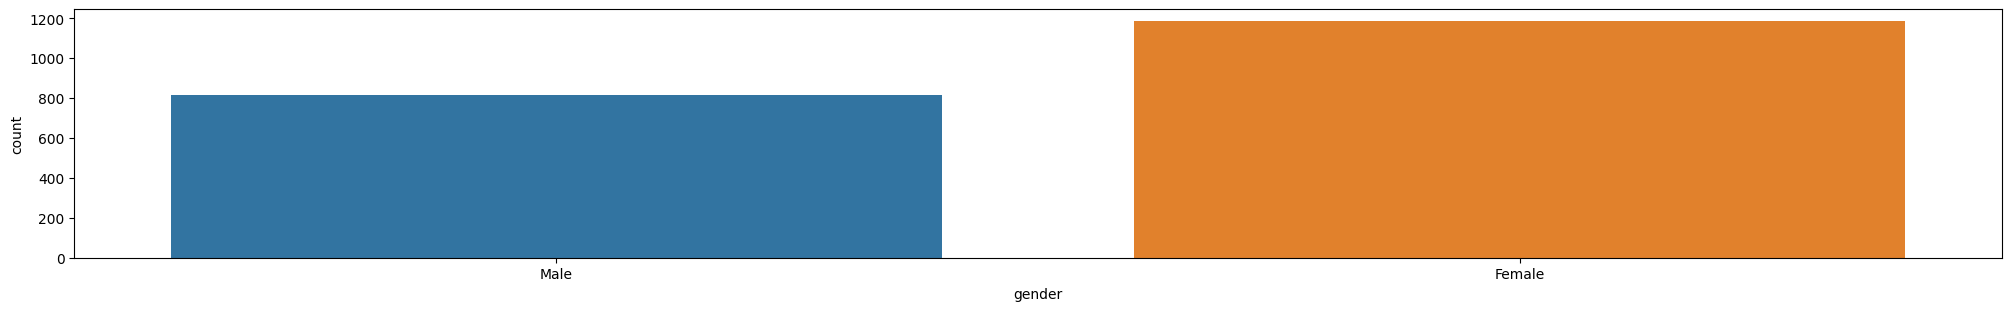

In [31]:
# gender

display(df['gender'].value_counts())
fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
sns.countplot(data=df, x='gender', ax=ax)

# 注目点としてはfemaleが372個多いという点（本来はそれほど差がないはず）
# 今回は目的変数がないので要素が2つのみのgenderとの関係を軸に確認していく

gender                                            
age_10s     0s  10s  20s  30s  40s  50s  60s 70s  80s  90s
gender                                                    
Female     117  121  122  142  119  131  122  94  111  107
Male        80   89   89   95   68   78   85  73   89   68

<Axes: xlabel='age_10s', ylabel='count'>

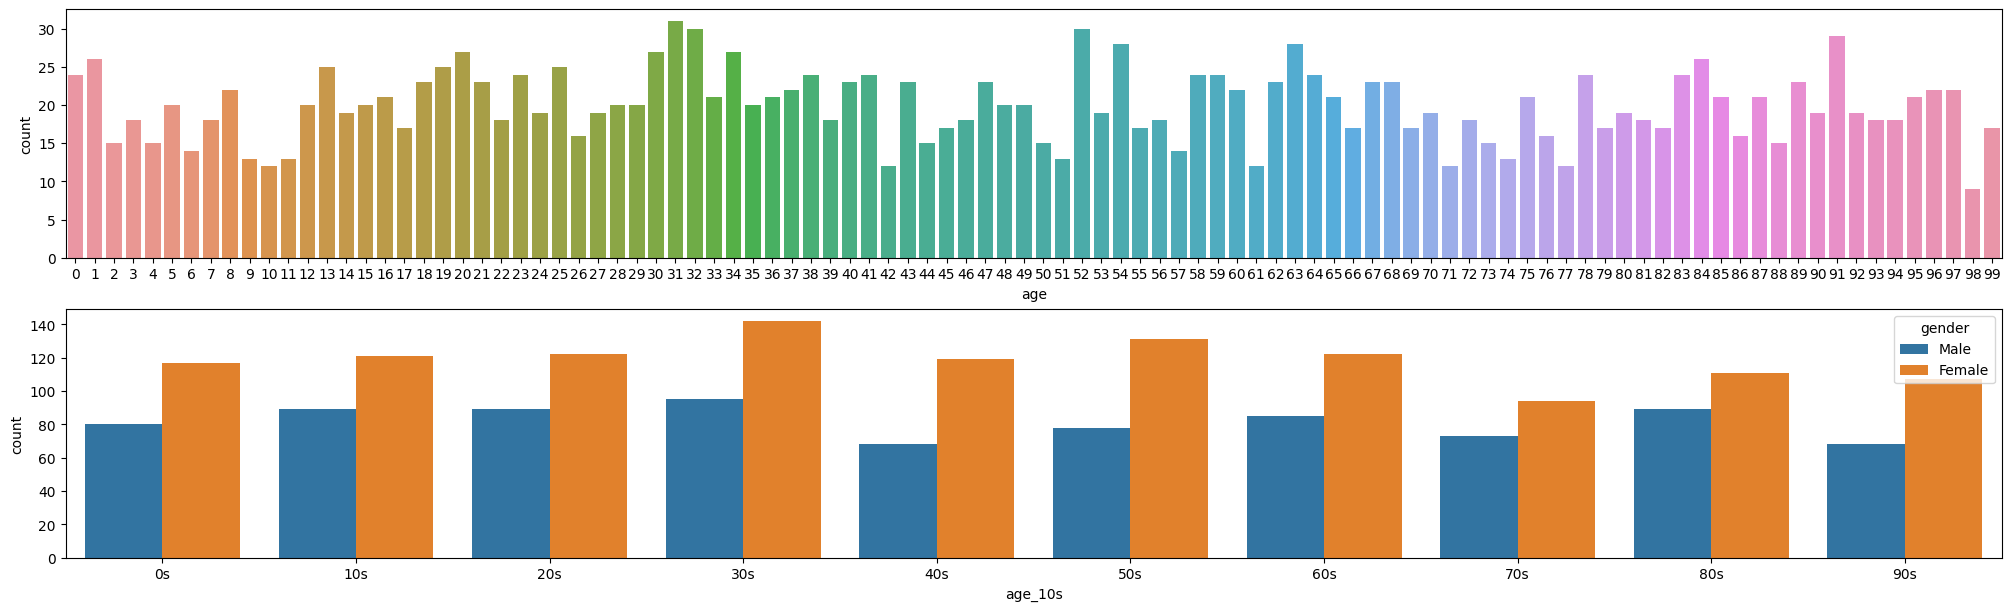

In [32]:
# age

df['age_10s'] = pd.cut(df['age'], [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                        labels=['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'] )

display(df.groupby(['gender', 'age_10s'])[['gender']].count().unstack())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='age', ax=ax1)
sns.countplot(data=df, x='age_10s', hue='gender', ax=ax2)

# このageの分布は明らかに不自然でこのような年齢分布を集める意味もわからない
# 保険会社の顧客にしては0歳児を始めとした未成年が多すぎるし高齢者も多すぎる
# 年齢層によりgenderのバラつきはあるが特段の傾向はみられない

,annual_income
gender,
Female,110553.715
Male,110991.323


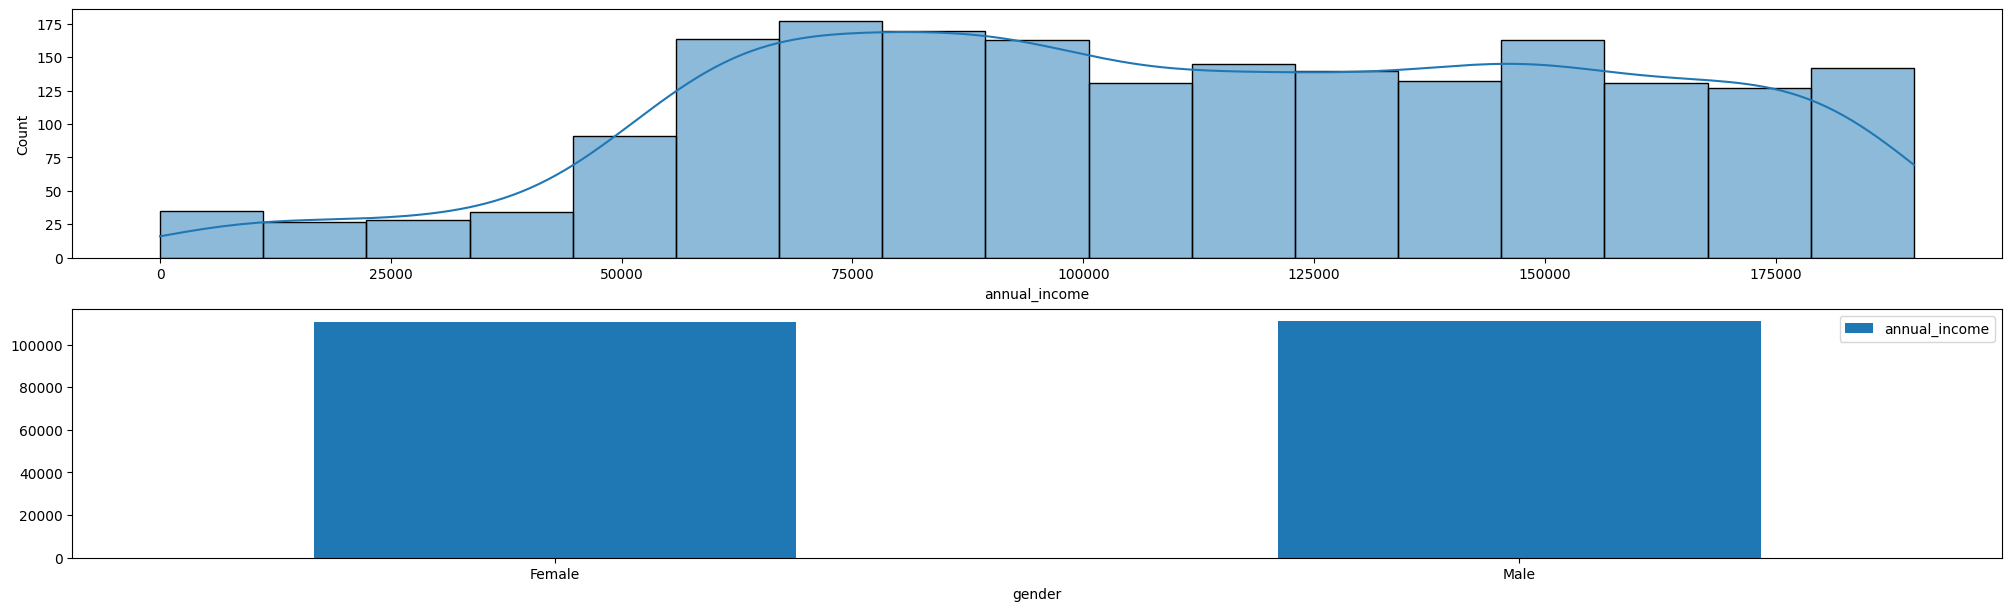

In [33]:
# annual_income

tmp = df.groupby('gender')[['annual_income']].mean()
display(tmp)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(data=df, x='annual_income', kde=True, ax=ax1)
tmp.plot(kind='bar', ax=ax2)
ax2.tick_params(axis='x', rotation=0)

# 年収の分布も不自然だが、低い年収の顧客は比較的少ない
# 平均年収は男性の方がわずかに高い

age_10s,0s,10s,20s,30s,40s,50s,60s,70s,80s,90s
gender,,,,,,,,,,
Female,53.906,48.000,52.451,50.930,48.067,48.336,53.418,47.096,55.018,52.402
Male,55.888,57.742,53.303,48.379,50.706,52.192,49.047,50.110,46.472,44.662


<Axes: xlabel='age_10s'>

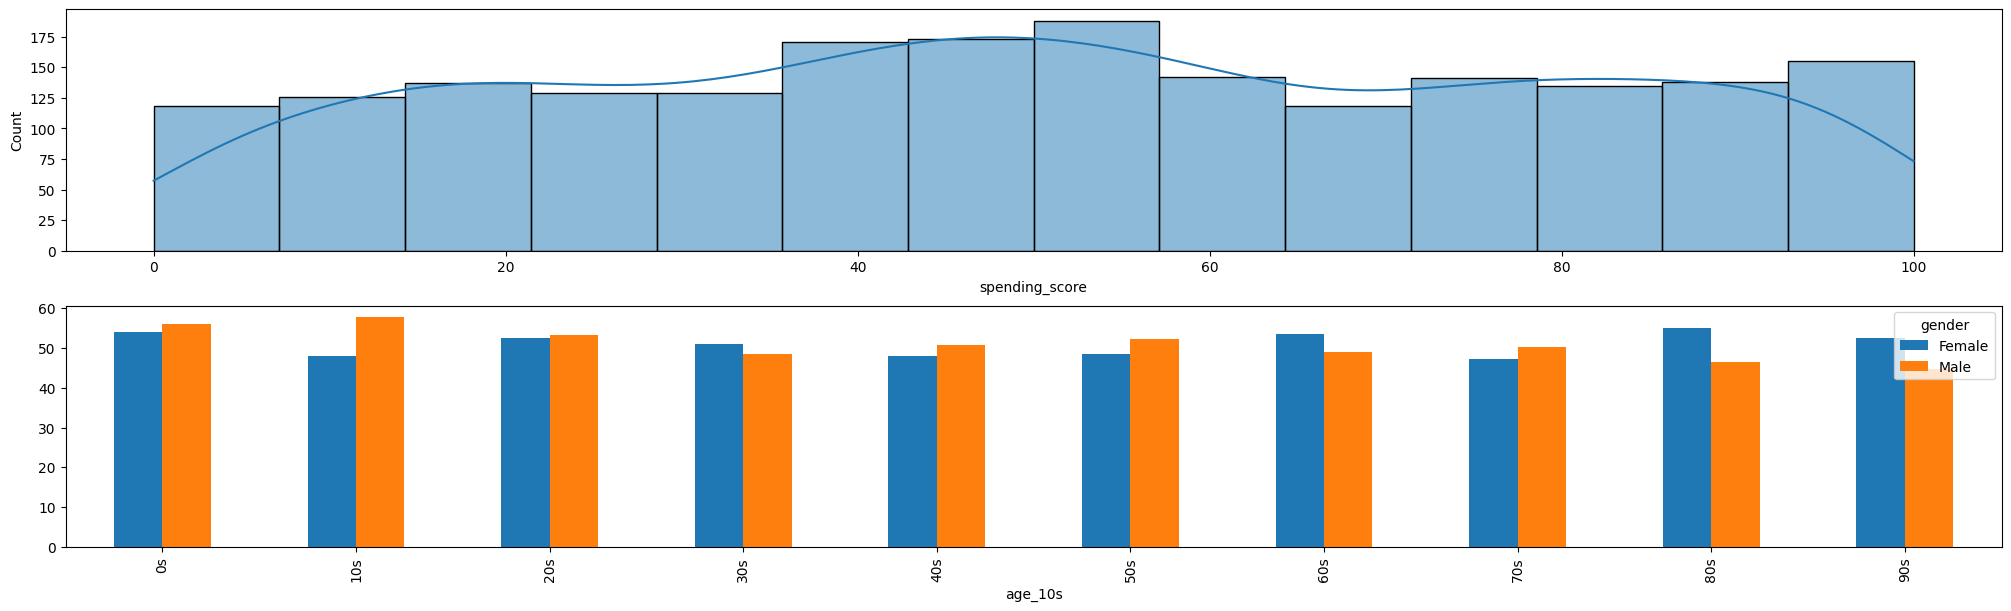

In [34]:
# spending_score

tmp2 = df.groupby(['gender', 'age_10s'])['spending_score'].mean().unstack()
display(tmp2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(data=df, x='spending_score', kde=True, ax=ax1)
tmp2.T.plot(kind='bar', ax=ax2)

# 支出スコアは全体として中心に寄っているようにも見えるがほぼ一様分布
# 年齢別にみても男女別にみてもある程度のバラつきはあるものの傾向らしきものは確認できない
# 支出スコアが何を意味するのかも不明だが、支出ゼロ付近の顧客とは何なのか理解に苦しむ

profession,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
gender,,,,,,,,,
Female,380,89,103,133,87,196,39,86,53
Male,232,72,76,101,66,143,21,56,32


<Axes: xlabel='profession', ylabel='count'>

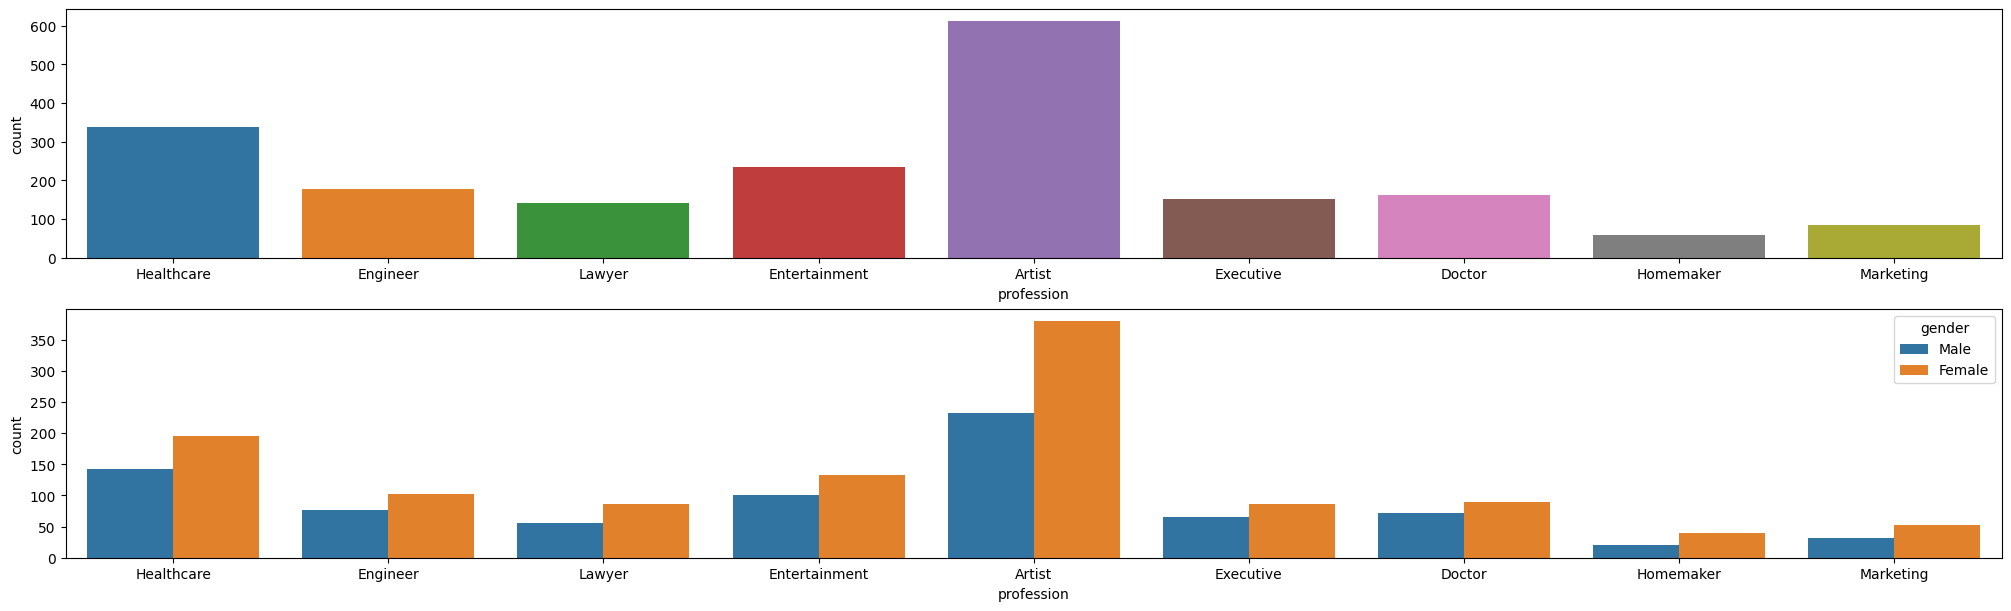

In [35]:
# profession

display(df.groupby(['profession', 'gender'])['gender'].count().unstack().T)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='profession', ax=ax1)
sns.countplot(data=df, x='profession', hue='gender', ax=ax2)

# Artistが突出して多く2番目がHelthcareだがこの設定もランダムで意味はなさそう
# Artistの女性比率が高い
# 職業の分布としてそもそもおかしいが、逆にこの課題の意図がこの順序尺度がなく数的な違いの大きい質的変数の取り扱いにあることが透けて見える
# それは、Artistだけが多いという情報を分類に生かせるようなエンコーディングが必要ということ

<Axes: xlabel='work_experience', ylabel='count'>

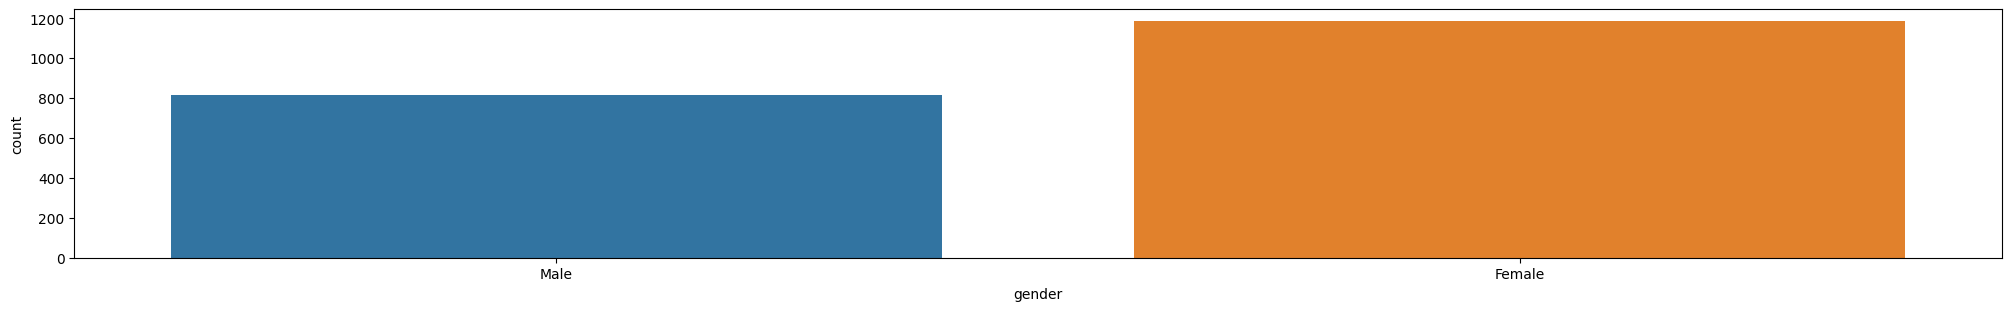

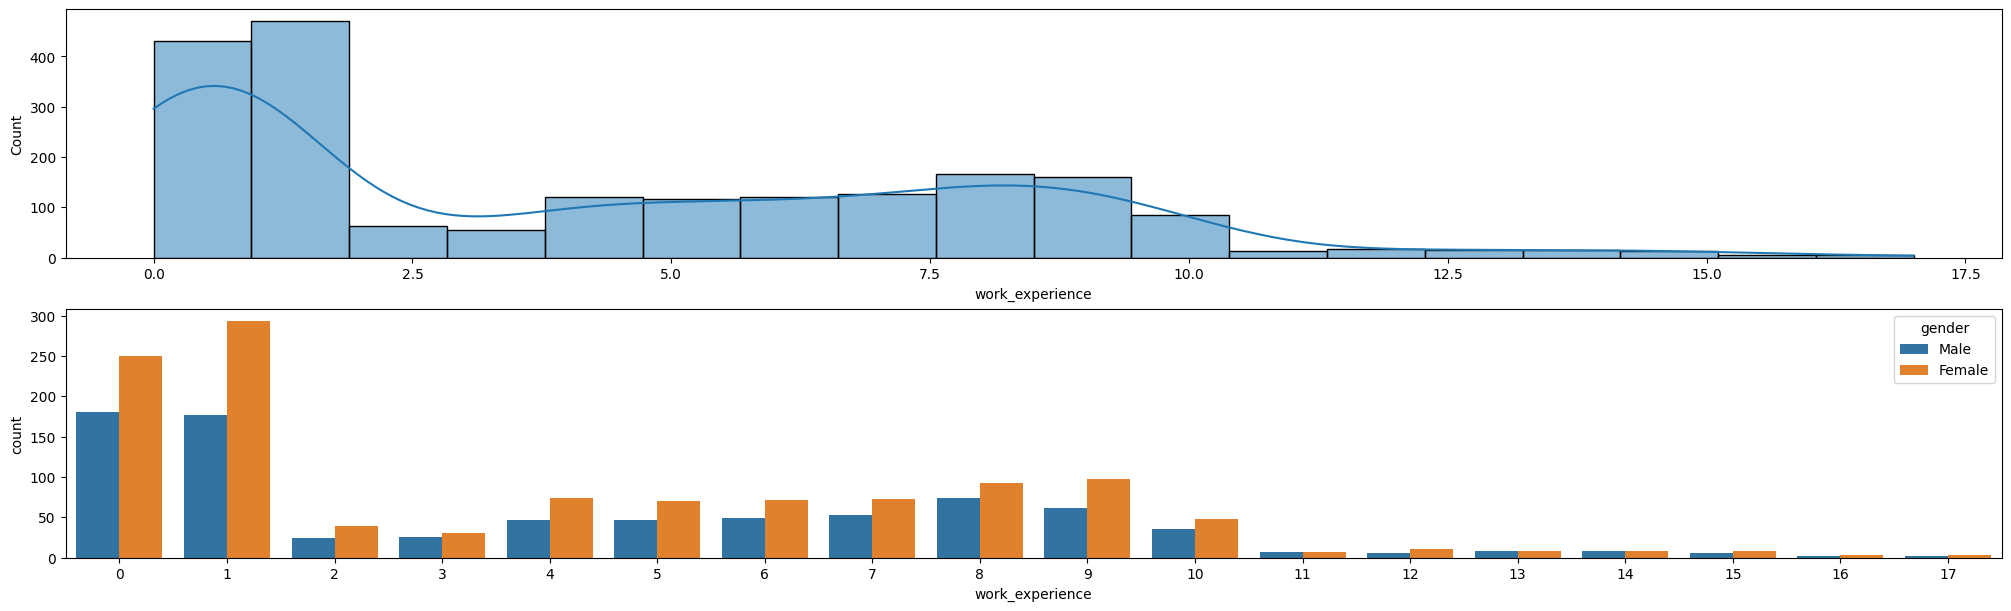

In [36]:
# work_experience

fig, ax = plt.subplots(figsize=(20, 3), layout='constrained')
sns.countplot(data=df, x='gender', ax=ax)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.histplot(data=df, x='work_experience', kde= True, ax=ax1)
sns.countplot(data=df, x='work_experience', hue='gender', ax=ax2)

# 平均年齢や年収が高いわりに職歴は短くこれも現実を反映した設定ではない
# 職歴1年以下が多く職歴1年の女性比率が高い
# ここもビニングすれば分類のキーとなり得るが今回は試していない。

<Axes: xlabel='spending_score', ylabel='family_size'>

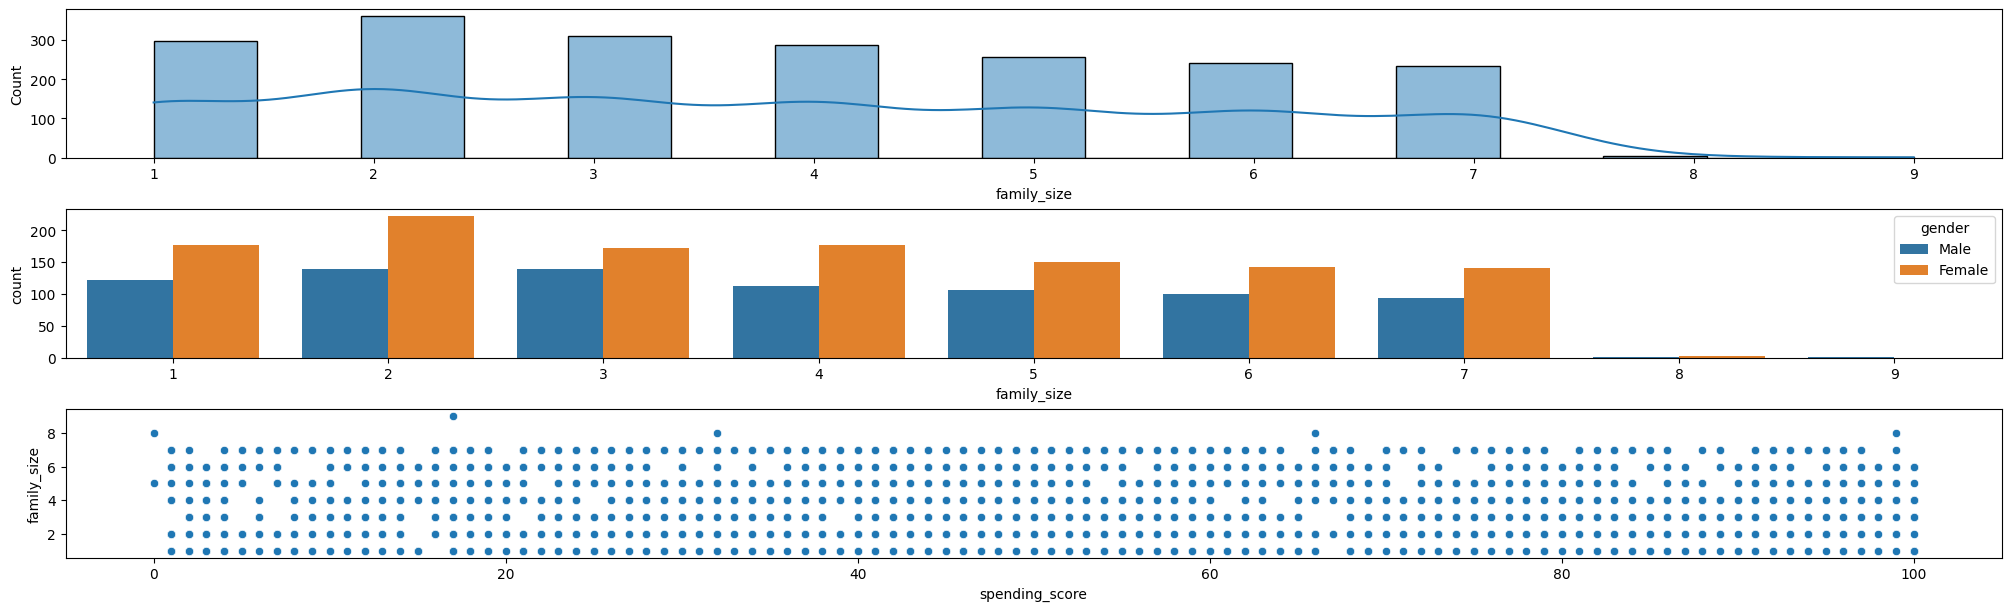

In [37]:
# family_size

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 6), layout='constrained')
sns.histplot(data=df, x='family_size', kde= True, ax=ax1)
sns.countplot(data=df, x='family_size', hue='gender', ax=ax2)
sns.scatterplot(data=df, x='spending_score', y='family_size', ax=ax3)

# 7人家族とかいつの時代のデータだろうと思うが7人までほぼ一様分布
# 男女の比率もあまり変わらない
# 念のためspending_scoreとの関係も見てみたが、案の定一様分布で何の関係も見られなかった。

### 結論、これは現実を描写した分布ではない
* 各要素はほぼ一様な分布になっている
* 男女や職業、職歴、年収などに一部差が設けられている
* 意図して作られたデータであるとすれば、あとは意図に沿ってクラスタリングするしかない

## クラスタリング

profession,3.0,4.0,5.0
profession,5,21,9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           2000 non-null   int64  
 1   age              2000 non-null   int64  
 2   annual_income    2000 non-null   int64  
 3   spending_score   2000 non-null   int64  
 4   profession       2000 non-null   float64
 5   work_experience  2000 non-null   int64  
 6   family_size      2000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 125.0 KB


<Axes: xlabel='profession', ylabel='Count'>

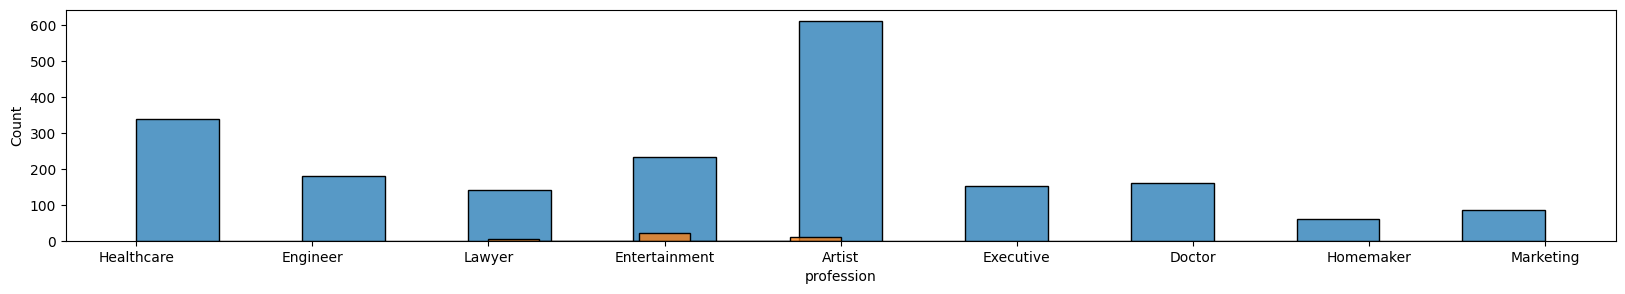

In [38]:
# 欠損値補完（profession）

df_missing = df.loc[df['profession'].isnull(), :]
df_train = df.loc[~df['profession'].isnull(), :]

df_train['gender'] = df_train['gender'].replace(['Male', 'Female'], [0, 1])
df_train['profession'] = df_train['profession'].replace(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing'], [1, 2, 3, 4, 5, 6, 7, 8, 9])
df_missing['gender'] = df_missing['gender'].replace(['Male', 'Female'], [0, 1])

X_train = df_train.drop(columns=['profession', 'age_10s'])
y_train = df_train['profession']
X_test = df_missing.drop(columns=['profession', 'age_10s'])

RFG_model = RFG()
RFG_model = RFG_model.fit(X_train, y_train)
RFG_pred = RFG_model.predict(X_test)

df_missing.loc[:, 'profession'] = np.round(RFG_pred)
df = pd.concat([df_missing, df_train])
df = df.reindex(range(2000))

df_c = df.drop(columns=['age_10s'])
df_c = df_c.set_index('index')
display(df_missing.groupby('profession')[['profession']].count().T)
df_c.info()

fig, ax = plt.subplots(figsize=(20, 3))
sns.histplot(data=df_train['profession'], ax=ax)
ax.set_xticklabels(['', 'Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', ''])
sns.histplot(data=df_missing['profession'], ax=ax)

# 35名いるprofessionの欠損値は、これも手がかりがないので機械学習で補完する
# 結果はLayer3,Entertainment21,Artist9となったが大勢に影響はない

In [39]:
# カウントエンコーディング

dict_profession = df_c['profession'].value_counts().to_dict()
dict_gender = df_c['gender'].value_counts().to_dict()

df_c['profession'] = df_c['profession'].map(dict_profession)
df_c['gender'] = df_c['gender'].map(dict_gender)
df_c.head()

# クラスタリングにはデータ間の距離や密度が必要なので、ワンホットエンコーディングは不適
# professionには順序もないのでgenderとともに固有の情報である要素の数を継承するカウントエンコーディングを行い数の情報を取り込む

,gender,age,annual_income,spending_score,profession,work_experience,family_size
index,,,,,,,
1,814,19,15000,39,339,1,4
2,814,21,35000,81,179,3,3
3,1186,20,86000,6,179,1,1
4,1186,23,59000,77,147,0,2
5,1186,31,38000,40,255,2,6


In [40]:
# ラベルエンコーディング

#dict_profession = df_c['profession'].value_counts().rank().to_dict()
#dict_gender = df_c['gender'].value_counts().rank().to_dict()

#df_c['profession'] = df_c['profession'].map(dict_profession)
#df_c['gender'] = df_c['gender'].map(dict_gender)
#df_c.head()

# カウントエンコーディングは不均衡データを強調するため数を反映しないカウント順のラベルエンコーディングも試した
# スコアはカウントエンコーディングの方が明確に分類できるため当然良い数値になる
# 解釈を勘案して多様で複雑な分類を試すには有用かもしれない
# こちらを試す場合は、カウントエンコーディングをコメントアウトしてこちらのコメントアウトを解除する

In [41]:
# 標準化

#df_c = np.log(df_c + 1)
df_c = stats.zscore(df_c)
df_c.head()

# 距離や密度を計るので次元削減やクラスタリングを行う上では本来標準化が必要とされる
# 対数変換はデータの分布が凡そ一様なので不要と思われる（行うとスコアが落ちる）
# 実際スコアには差がでるが、標準化しなくても数値に変換されていれば一応分類はしてくれることを確認済
# 標準化を行わない場合の可視化がどうなるかは一見の価値があるので是非試してみて欲しい
# このセルをコメントアウトして全体をRun Allすれば良い

,gender,age,annual_income,spending_score,profession,work_experience,family_size
index,,,,,,,
1,-1.207,-1.054,-2.094,-0.428,-0.003,-0.791,0.117
2,-1.207,-0.984,-1.656,1.076,-0.795,-0.281,-0.390
3,0.828,-1.019,-0.541,-1.610,-0.795,-0.791,-1.405
4,0.828,-0.913,-1.131,0.932,-0.953,-1.046,-0.898
5,0.828,-0.632,-1.591,-0.393,-0.419,-0.536,1.133


[2 2 4 ... 2 2 2]
2    586
1    567
4    561
3    286
dtype: int64
silhouette_score: 0.11100072053207242
dbi_score       : 2.2268676956009137
chi_score       : 229.44504410356


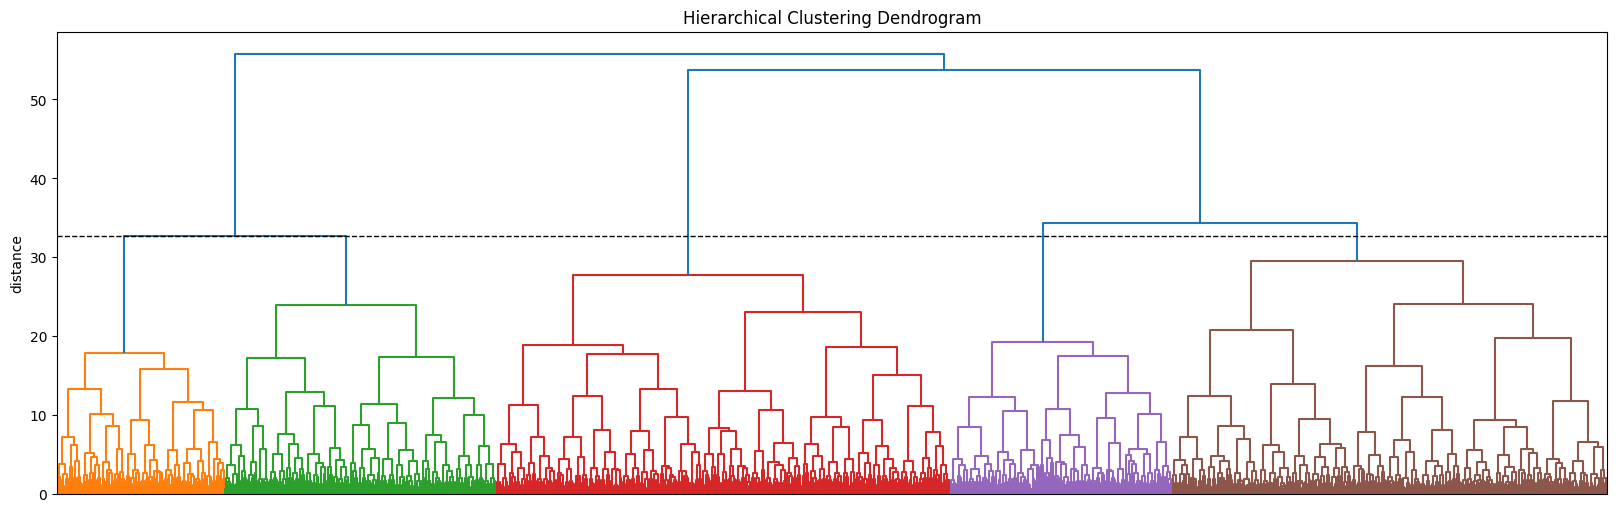

In [42]:
# 階層型クラスタリング

# Compute the linkage matrix
Z = sch.linkage(df_c, 'ward')

# Form flat clusters
k = 4  # desired number of clusters
clusters = sch.fcluster(Z, k, criterion='maxclust')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(20, 6))
dn = sch.dendrogram(Z, color_threshold=Z[-k, 2])

ax.axhline(y=Z[-k, 2], c='black', lw=1, linestyle='dashed')
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_ylabel('distance')
ax.set_xticks([])

print(clusters)
print(pd.DataFrame(clusters).value_counts())

# クラスタリング評価
score = silhouette_score(df_c, clusters)
dbi = davies_bouldin_score(df_c, clusters)
chi = calinski_harabasz_score(df_c, clusters)
print(f'silhouette_score: {score}')
print(f'dbi_score       : {dbi}')
print(f'chi_score       : {chi}')

# 次元縮約なしでの階層型クラスタリングも一応確認しておく
# 解釈で補完するのでこれで問題ないといえば問題ないがクラスタリングスコアは良くない
# なお、次元縮約しない場合は、標準化も外すとそれなりのスコアになる

In [43]:
# PCA及び多様体モデルによる次元縮約

models = [PCA(n_components=2), Isomap(n_neighbors=20), MDS(n_init=10),
          LocallyLinearEmbedding(n_neighbors=50),
          SpectralEmbedding(), TSNE(),
          umap.UMAP(n_neighbors=20, min_dist=0.05, random_state=42)]
m_names = ['pca', 'iso', 'mds', 'lle', 'se', 'tsne', 'umap']

X = {}
for m_name, model in zip(m_names, models):
    manifolder = model
    if model == PCA or model == Isomap:
        manifolder = manifolder.fit(df_c)
        X[m_name] = manifolder.transform(df_c)
    else:
        X[m_name] = manifolder.fit_transform(df_c)

# 7次元（7特徴量）を2次元に変換して可視化する
# 次元縮約やクラスタリングに決定版はないのでパラメータ設定も含めた試行錯誤が必要らしい
# ここでは代表的な主成分分析（PCA）と、7種類の多様体モデル（manifolder）による非線形縮約を試した
# 少し時間のかかる計算負荷の高いモデルも含まれているので、実用的には軽いモデルを使うのが良いと思う(UMAPなど)
# 線形で分かりやすいPCAが基本だが、このデータの場合はほとんど一様分布なのでうまく機能しない

In [44]:
pprint(X)

# 各々float型の2次元データになっている

{'iso': array([[ 4.652,  0.14 ],
       [ 4.236,  2.6  ],
       [-2.999,  0.839],
       ...,
       [ 4.404,  0.992],
       [ 4.175,  2.575],
       [ 5.085,  1.532]]),
 'lle': array([[ 0.015,  0.025],
       [ 0.018,  0.03 ],
       [-0.026,  0.042],
       ...,
       [ 0.03 ,  0.017],
       [ 0.036,  0.004],
       [ 0.027,  0.016]]),
 'mds': array([[ 2.887, -0.642],
       [ 2.582, -0.996],
       [ 2.819, -0.316],
       ...,
       [ 1.67 , -2.254],
       [-0.066, -3.375],
       [ 0.654, -1.344]]),
 'pca': array([[-1.651, -0.895],
       [-1.385, -0.14 ],
       [-1.433, -1.327],
       ...,
       [ 0.387, -1.674],
       [ 1.595, -1.777],
       [ 0.181, -1.006]]),
 'se': array([[ 2.121e-03,  3.212e-04],
       [ 1.983e-03,  3.476e-05],
       [-1.290e-03, -1.091e-03],
       ...,
       [ 2.018e-03, -3.159e-04],
       [ 1.888e-03, -1.192e-03],
       [ 2.459e-03, -3.381e-04]]),
 'tsne': array([[ 13.857, -26.801],
       [ 11.805, -25.285],
       [-13.472,  47.273],
   

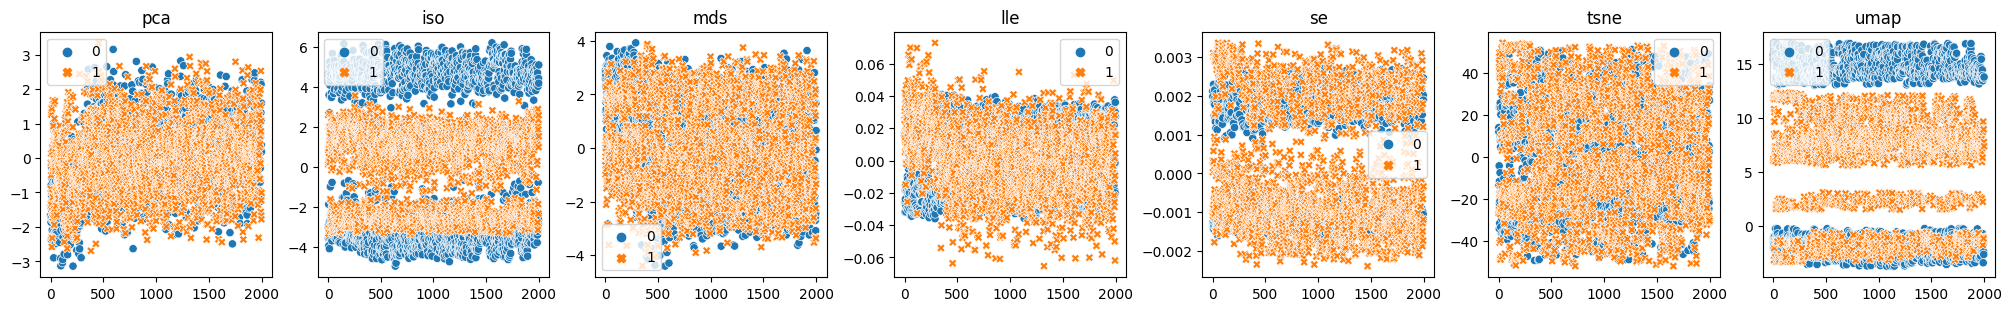

In [45]:
# 可視化

fig, ax = plt.subplots(1, 7, figsize=(20, 3), layout='constrained')
m_names = ['pca', 'iso', 'mds', 'lle', 'se', 'tsne', 'umap']
for i, m_name in enumerate(m_names):
    sns.scatterplot(X[m_name], ax=ax[i])
    ax[i].set_title(m_names[i])

# 元の座標上で分類を色分けしただけではほとんど混在しているように見える・・・

kmeans                                           dbscan                ...  \
      pca    iso    mds    lle     se   tsne   umap    pca    iso    mds  ...   
-1    0.0    0.0    0.0    0.0    0.0    0.0    0.0      3   41.0    0.0  ...   
 0  457.0  398.0  450.0  624.0  572.0  242.0  386.0     98  516.0  836.0  ...   
 1  536.0  276.0  526.0  442.0  793.0  800.0  579.0     65    9.0  280.0  ...   
 2  544.0  788.0  476.0  549.0  393.0  572.0  800.0    190  771.0   80.0  ...   
 3  463.0  538.0  548.0  385.0  242.0  386.0  235.0    227  349.0  115.0  ...   
 4    0.0    0.0    0.0    0.0    0.0    0.0    0.0     29  205.0  248.0  ...   
 5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    139   16.0  128.0  ...   
 6    0.0    0.0    0.0    0.0    0.0    0.0    0.0     53    6.0   41.0  ...   
 7    0.0    0.0    0.0    0.0    0.0    0.0    0.0     85    4.0   59.0  ...   
 8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    118   20.0   94.0  ...   

       gmm               hierarchy                                            
        se   tsne   umap       pca    iso    mds    lle     se   tsne   umap  
-1     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 0     0.0  361.0  579.0     376.0  237.0  271.0  257.0  235.0  235.0  235.0  
 1  1436.0  386.0  800.0     367.0  577.0  529.0  561.0  386.0  579.0  579.0  
 2   564.0  814.0  386.0     694.0  386.0  375.0  548.0  579.0  386.0  386.0  
 3     0.0  439.0  235.0     563.0  800.0  825.0  634.0  800.0  800.0  800.0  
 4     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 5     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 6     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 7     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  
 8     0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[10 rows x 28 columns]

sil (-1<>1, big is better)                          \
clustering_model                     dbscan    gmm hierarchy kmeans   
manifold_model                                                        
iso                                   0.146  0.652     0.652  0.656   
lle                                   0.018  0.457     0.439  0.456   
mds                                   0.072  0.358     0.312  0.364   
pca                                  -0.045  0.319     0.289  0.320   
se                                    0.169  0.437     0.722  0.722   
tsne                                  0.180  0.478     0.567  0.566   
umap                                  0.624  0.793     0.793  0.793   

                 dbi (small is better)                          \
clustering_model                dbscan    gmm hierarchy kmeans   
manifold_model                                                   
iso                              2.184  0.469     0.469  0.485   
lle                              2.231  0.747     0.723  0.724   
mds                              1.977  0.857     0.877  0.827   
pca                              4.238  0.936     1.006  0.934   
se                               1.375  0.820     0.371  0.377   
tsne                             1.622  0.764     0.554  0.560   
umap                             1.457  0.289     0.289  0.289   

                 chi (big is better)                                   
clustering_model              dbscan        gmm  hierarchy     kmeans  
manifold_model                                                         
iso                         2015.785  11090.463  11115.737  11681.479  
lle                          450.664   2128.191   2151.230   2289.027  
mds                          508.011   1576.437   1303.824   1683.881  
pca                          285.318   1267.007   1090.993   1293.016  
se                          1801.857   1156.510   7491.503   7556.535  
tsne                        1583.641   2521.124   3676.411   3677.118  
umap                       12917.293  32617.695  32617.695  32617.695

[]

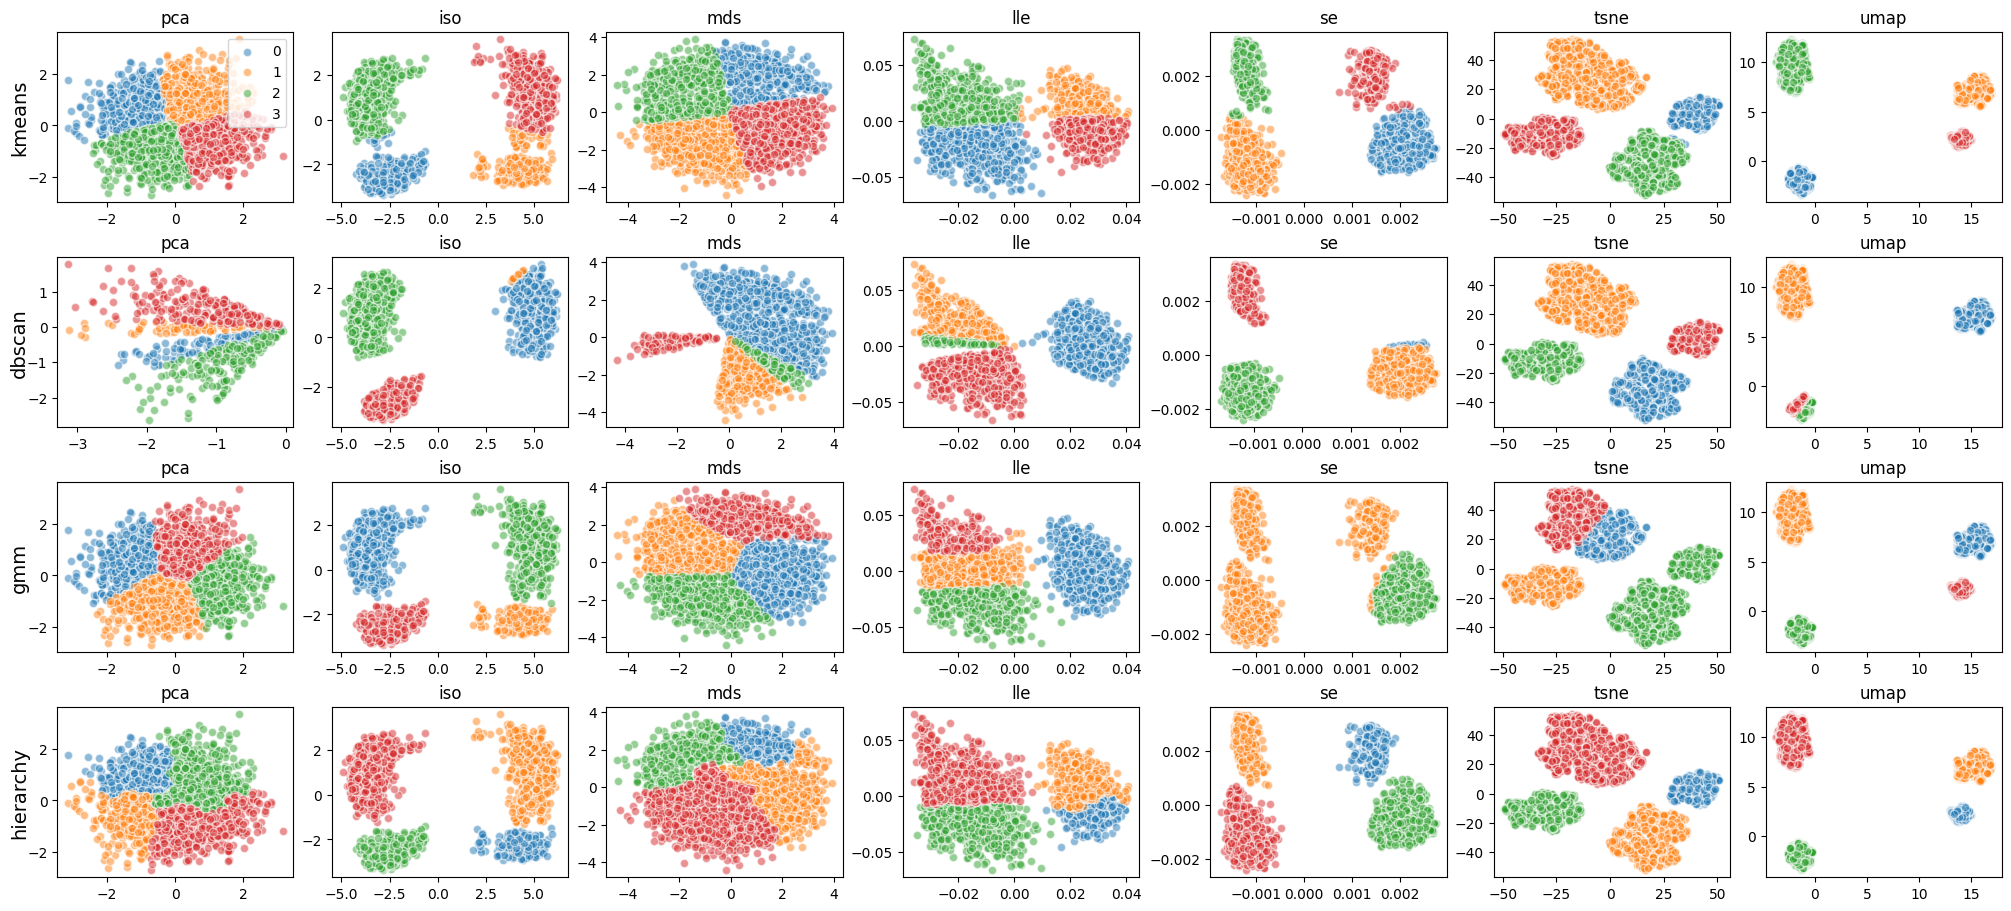

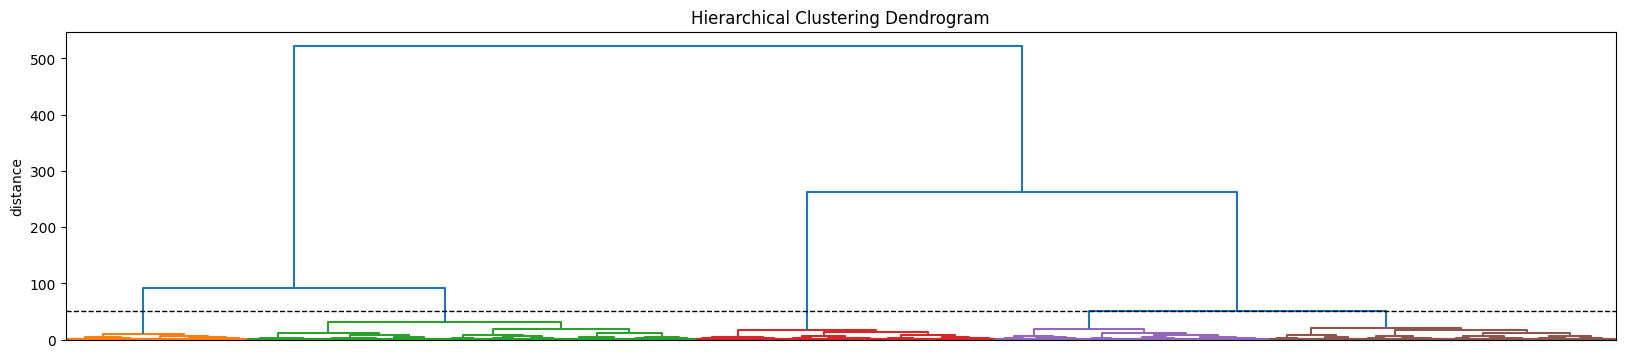

In [46]:
# クラスタリングと可視化

clustring_models = [KMeans(n_clusters=4, random_state=42),
                    DBSCAN(eps=0.0001, min_samples=4, metric='cosine'),
                    GaussianMixture(n_components=4),
                    sch.fcluster(Z, k, criterion='maxclust')]
c_names = ['kmeans', 'dbscan', 'gmm', 'hierarchy']                       # クラスタリングモデルは4つ
m_names = ['pca', 'iso', 'mds', 'lle', 'se', 'tsne', 'umap']             # PCA、多様体モデルは合計7つ

# 次元縮約、クラスタリングモデル別可視化
dic_clusters = {}
fig, ax = plt.subplots(4, 7, figsize=(20, 9), layout='constrained')
for i, (c_name, c_model) in enumerate(zip(c_names, clustring_models)):
    # クラスタリングモデル名をグラフ行の左側に表示
    ax[i, 0].text(-0.2, 0.5, c_name, transform=ax[i, 0].transAxes,
                   fontsize=14, va='center', rotation='vertical')
    # モデル別にクラスタリングを実施
    for j, m_name in enumerate(m_names):
        if c_name == 'hierarchy':
            Z = sch.linkage(X[m_name], 'ward')
            k = 4
            clusters = sch.fcluster(Z, k, criterion='maxclust')-1
            dic_clusters[(c_name, m_name)] = clusters
        else:
            clusters = c_model.fit_predict(X[m_name])
            dic_clusters[(c_name, m_name)] = clusters
        # 以下、グラフ描画
        for class_value in range(4):
            idx = np.where(clusters == class_value)
            ax[i, j].scatter(X[m_name][idx, 0], X[m_name][idx, 1], label=class_value,
                             alpha= 0.5, edgecolors='white')
            ax[0, 0].legend(loc='upper right')
            ax[i, j].set_title(m_name)

# モデル別クラスタリング表
df_value_counts = pd.DataFrame()
df_clusters = pd.DataFrame().from_dict(dic_clusters)
df_value_counts = df_clusters.apply(pd.value_counts).fillna(0)
display(df_value_counts.head(10))

# クラスタリング評価
dic_evaluation = defaultdict(list)
for c_name in c_names:
    for m_name in m_names:
        score = silhouette_score(X[m_name], dic_clusters[(c_name, m_name)])
        dbi = davies_bouldin_score(X[m_name], dic_clusters[(c_name, m_name)])
        chi = calinski_harabasz_score(X[m_name], dic_clusters[(c_name, m_name)])
        dic_evaluation['clustering_model'].append(c_name)
        dic_evaluation['manifold_model'].append(m_name)
        dic_evaluation['sil (-1<>1, big is better)'].append(score)
        dic_evaluation['dbi (small is better)'].append(dbi)
        dic_evaluation['chi (big is better)'].append(chi)

df_evaluation = pd.DataFrame().from_dict(dic_evaluation)
display(df_evaluation.groupby(['manifold_model','clustering_model']).sum().unstack())

# dendrogram描画
fig, ax = plt.subplots(figsize=(20, 4))
dn = sch.dendrogram(Z, color_threshold=Z[-k, 2])
ax.axhline(y=Z[-k, 2], c='black', lw=1, linestyle='dashed')
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_ylabel('distance')
ax.set_xticks([])

# 次元縮約したデータを変換後の軸で可視化し、複数のクラスタリングモデルで分割する
# 組み合わせの数が多いので可視化から評価指標3種類による評価まで一連のコードで纏めた
# クラスタリングモデルのうち、DBSCANはクラスタ数を指定できないのでここでは参考扱い
# 代表的なモデルとされるKMeansおよびscipyの階層型モデルhierarckyとUMAPの組み合わせのスコアが良好
# （グラフを見れば一目瞭然だが、各クラスタが独立していてクラスタ同士が離れているということ）
# なお、クラスタ数が最も均一なのはKMeansとpcaの組み合わせ（残念ながらスコアは最低、つまり分類になっていない）
# 各モデルはパラメータにかなり依存するので各々試行錯誤が必要

* 多様体モデルの次元削減に関しては標準化した場合としない場合でグラフの形状が大きく異なる
* 標準化なしの場合はおそらくはパラメータで形状は変化するものの初期設定に近いグラフ形状になっていると考えられる


## クラスタリングの解釈

In [47]:
# 元のデータフレーム(標準化後)にクラスタ番号を還元

for i in dic_clusters:
    df_c[i] = dic_clusters[i]
df_c

,gender,age,annual_income,spending_score,profession,work_experience,family_size,"(kmeans, pca)","(kmeans, iso)","(kmeans, mds)",...,"(gmm, se)","(gmm, tsne)","(gmm, umap)","(hierarchy, pca)","(hierarchy, iso)","(hierarchy, mds)","(hierarchy, lle)","(hierarchy, se)","(hierarchy, tsne)","(hierarchy, umap)"
index,,,,,,,,,,,,,,,,,,,,,
1,-1.207,-1.054,-2.094,-0.428,-0.003,-0.791,0.117,2,3,3,...,2,2,0,1,1,1,1,2,1,1
2,-1.207,-0.984,-1.656,1.076,-0.795,-0.281,-0.390,0,3,3,...,2,2,0,1,1,1,1,2,1,1
3,0.828,-1.019,-0.541,-1.610,-0.795,-0.791,-1.405,2,2,3,...,1,3,1,1,3,1,3,3,3,3
4,0.828,-0.913,-1.131,0.932,-0.953,-1.046,-0.898,0,2,3,...,1,3,1,0,3,1,3,3,3,3
5,0.828,-0.632,-1.591,-0.393,-0.419,-0.536,1.133,2,2,3,...,1,3,1,1,3,1,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.828,0.775,1.611,-0.393,1.392,0.994,1.640,1,0,2,...,1,1,2,2,2,2,2,1,2,2
1997,0.828,1.479,-0.822,-0.679,-0.884,0.739,1.640,3,2,1,...,1,0,1,3,3,3,2,3,3,3
1998,-1.207,1.338,-0.432,-1.324,-0.003,1.249,-0.898,2,3,3,...,2,2,0,3,1,3,1,2,1,1


In [48]:
# ラベルデコーダ

df['gender'] = df['gender'].replace([0, 1],['male', 'female'])
df['profession'] = df['profession'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9],
                    ['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
                     'Executive', 'Doctor', 'Homemaker', 'Marketing'])

dic_decode1 = dict(zip(df_c['gender'],df['gender']))
dic_decode2 = dict(zip(df_c['profession'],df['profession']))

pprint(dic_decode1)
pprint(dic_decode2)

# 可視化用に変換辞書を用意

{-1.2070635679211172: 'male', 0.8284567827047128: 'female'}
{-1.3835765218809515: 'Homemaker',
 -1.2599086358653353: 'Marketing',
 -0.9532122785466073: 'Lawyer',
 -0.9235319859028593: 'Executive',
 -0.8839582623778621: 'Doctor',
 -0.7949173844466185: 'Engineer',
 -0.4189670109591453: 'Entertainment',
 -0.0034429139466748853: 'Healthcare',
 1.3915308403094757: 'Artist'}


,,0,1,2,3
gmm,pca,433,612,453,502


,,0,1,2,3
hierarchy,iso,237,577,386,800


,,0,1,2,3
gmm,mds,592,518,473,417


,,0,1,2,3
kmeans,lle,624,442,549,385


,,0,1,2,3
kmeans,se,572,793,393,242


,,0,1,2,3
hierarchy,tsne,235,579,386,800


,,0,1,2,3
hierarchy,umap,235,579,386,800


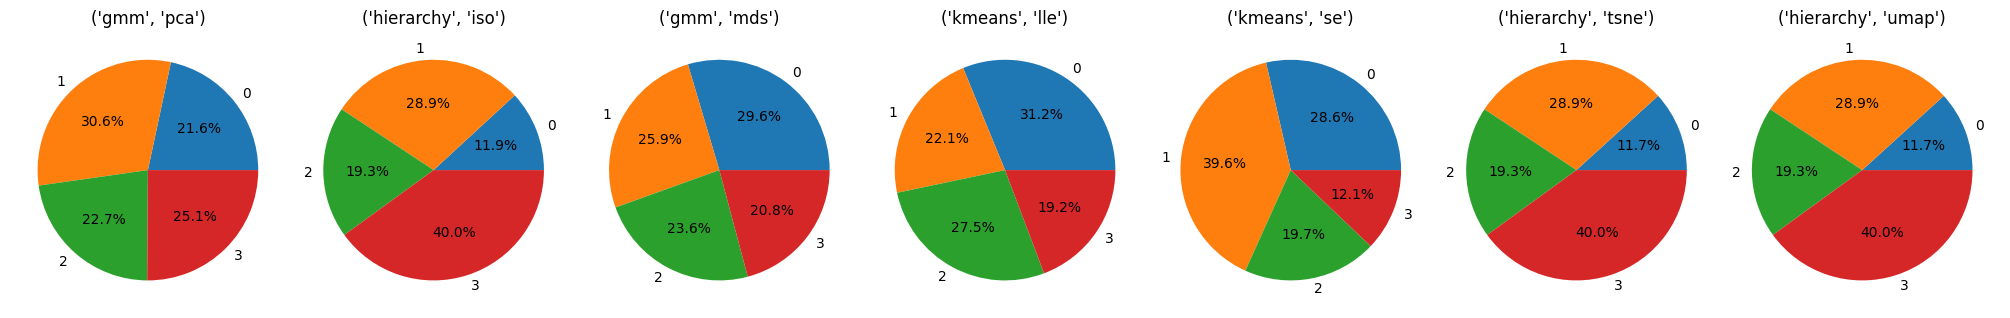

In [49]:
# 各クラスタにおける元の特徴量の平均、平均出現率
clusters = [('gmm', 'pca'),('hierarchy','iso'), ('gmm', 'mds'), ('kmeans', 'lle'),
            ('kmeans', 'se'), ('hierarchy', 'tsne'), ('hierarchy', 'umap')]

fig, ax = plt.subplots(1, 7, figsize=(20,3), layout='constrained')
for i, cluster in enumerate(clusters):
    df_01 = pd.DataFrame(df_c[cluster].value_counts().sort_index())
    ax[i].pie(x=df_01[(cluster)], labels=df_01.index, autopct='%1.1f%%')
    ax[i].set_title(cluster)
    display(df_01.T)
plt.show()

# スコアや分類状況を参考にいくつかサンプルをとって比較してみた
# PCA、mds以外は次元縮約の段階でクラスタリングが進んでいるためクラスタ間の比率がまちまち
# 逆にPCAとmdsはクラスタリングスコアは低いものの比較的均等という結果になっている
# ちなみにクラスタリング番号はランダムに設定されているので数字の入り繰りは仕様

cluster,0,1,2,3
"(gmm, pca)",,,,
male,0.27,0.492,0.523,0.317
female,0.73,0.508,0.477,0.683


cluster,0,1,2,3
"(hierarchy, iso)",,,,
male,1.0,1.0,NaN,NaN
female,NaN,NaN,1.0,1.0


cluster,0,1,2,3
"(gmm, mds)",,,,
male,0.421,0.164,0.719,0.336
female,0.579,0.836,0.281,0.664


cluster,0,1,2,3
"(kmeans, lle)",,,,
male,NaN,0.982,NaN,0.987
female,1.0,0.018,1.0,0.013


cluster,0,1,2,3
"(kmeans, se)",,,,
male,1.0,NaN,NaN,1.0
female,NaN,1.0,1.0,NaN


cluster,0,1,2,3
"(hierarchy, tsne)",,,,
male,1.0,1.0,NaN,NaN
female,NaN,NaN,1.0,1.0


cluster,0,1,2,3
"(hierarchy, umap)",,,,
male,1.0,1.0,NaN,NaN
female,NaN,NaN,1.0,1.0


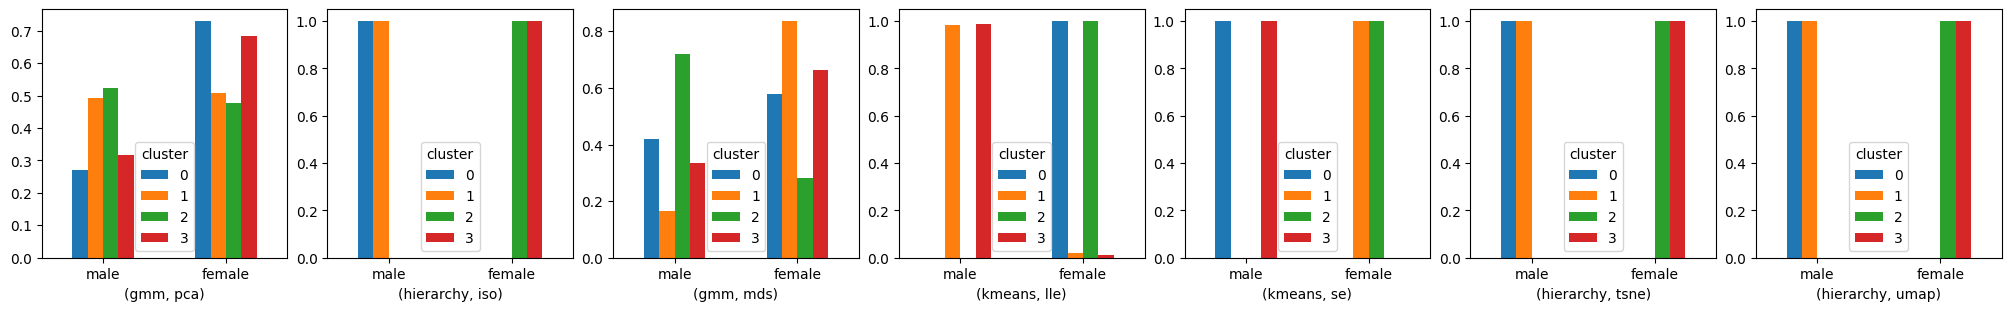

In [50]:
# gender

fig, ax = plt.subplots(1, 7, figsize=(20,3), layout='constrained')
for i, cluster in enumerate(clusters):
    df_03 = (df_c.groupby(cluster)['gender'].value_counts()\
        / df_c.groupby(cluster)['gender'].count()).unstack()
    df_03 = pd.DataFrame(df_03.values,
                         columns=[dic_decode1[df_03.columns[0]], dic_decode1[df_03.columns[1]]],
                         index=[0, 1, 2, 3])
    df_03.index.name = 'cluster'
    df_03.columns.name = cluster
    df_03.T.plot(kind='bar', ax=ax[i])
    ax[i].tick_params(axis='x', rotation=0)
    display(df_03.T)
plt.show()

# maleとfemaleの違いが大きいため、pcaとmds以外はほぼほぼmaleとfemaleで分割

cluster,0,1,2,3
"(gmm, pca)",,,,
Homemaker,0.007,0.049,0.053,0.006
Marketing,0.016,0.060,0.060,0.028
Lawyer,0.037,0.111,0.095,0.040
Executive,0.051,0.093,0.121,0.038
Doctor,0.053,0.100,0.117,0.048
Engineer,0.048,0.132,0.110,0.054
Entertainment,0.081,0.160,0.146,0.112
Healthcare,0.127,0.183,0.166,0.193
Artist,0.580,0.111,0.132,0.482


cluster,0,1,2,3
"(hierarchy, iso)",,,,
Homemaker,NaN,0.036,NaN,0.049
Marketing,NaN,0.055,NaN,0.066
Lawyer,NaN,0.102,NaN,0.110
Executive,NaN,0.114,NaN,0.109
Doctor,NaN,0.125,NaN,0.111
Engineer,NaN,0.132,NaN,0.129
Entertainment,NaN,0.191,NaN,0.181
Healthcare,0.013,0.243,NaN,0.245
Artist,0.987,0.002,1.0,NaN


cluster,0,1,2,3
"(gmm, mds)",,,,
Homemaker,0.046,0.004,0.066,NaN
Marketing,0.064,0.015,0.082,NaN
Lawyer,0.113,0.048,0.116,NaN
Executive,0.108,0.062,0.118,0.002
Doctor,0.117,0.042,0.148,NaN
Engineer,0.128,0.073,0.137,NaN
Entertainment,0.171,0.149,0.152,0.012
Healthcare,0.233,0.226,0.161,0.019
Artist,0.020,0.380,0.019,0.966


cluster,0,1,2,3
"(kmeans, lle)",,,,
Homemaker,0.021,0.038,0.047,0.010
Marketing,0.030,0.059,0.062,0.016
Lawyer,0.051,0.100,0.102,0.039
Executive,0.059,0.102,0.091,0.055
Doctor,0.062,0.109,0.089,0.065
Engineer,0.067,0.120,0.111,0.060
Entertainment,0.109,0.147,0.138,0.119
Healthcare,0.171,0.170,0.157,0.184
Artist,0.428,0.156,0.202,0.452


cluster,0,1,2,3
"(kmeans, se)",,,,
Homemaker,0.037,0.049,NaN,NaN
Marketing,0.056,0.067,NaN,NaN
Lawyer,0.103,0.111,NaN,NaN
Executive,0.115,0.110,NaN,NaN
Doctor,0.126,0.112,NaN,NaN
Engineer,0.133,0.130,NaN,NaN
Entertainment,0.192,0.183,NaN,NaN
Healthcare,0.238,0.238,0.018,0.029
Artist,NaN,NaN,0.982,0.971


cluster,0,1,2,3
"(hierarchy, tsne)",,,,
Homemaker,NaN,0.036,NaN,0.049
Marketing,NaN,0.055,NaN,0.066
Lawyer,NaN,0.102,NaN,0.110
Executive,NaN,0.114,NaN,0.109
Doctor,NaN,0.124,NaN,0.111
Engineer,NaN,0.131,NaN,0.129
Entertainment,NaN,0.190,NaN,0.181
Healthcare,NaN,0.247,NaN,0.245
Artist,1.0,NaN,1.0,NaN


cluster,0,1,2,3
"(hierarchy, umap)",,,,
Homemaker,NaN,0.036,NaN,0.049
Marketing,NaN,0.055,NaN,0.066
Lawyer,NaN,0.102,NaN,0.110
Executive,NaN,0.114,NaN,0.109
Doctor,NaN,0.124,NaN,0.111
Engineer,NaN,0.131,NaN,0.129
Entertainment,NaN,0.190,NaN,0.181
Healthcare,NaN,0.247,NaN,0.245
Artist,1.0,NaN,1.0,NaN


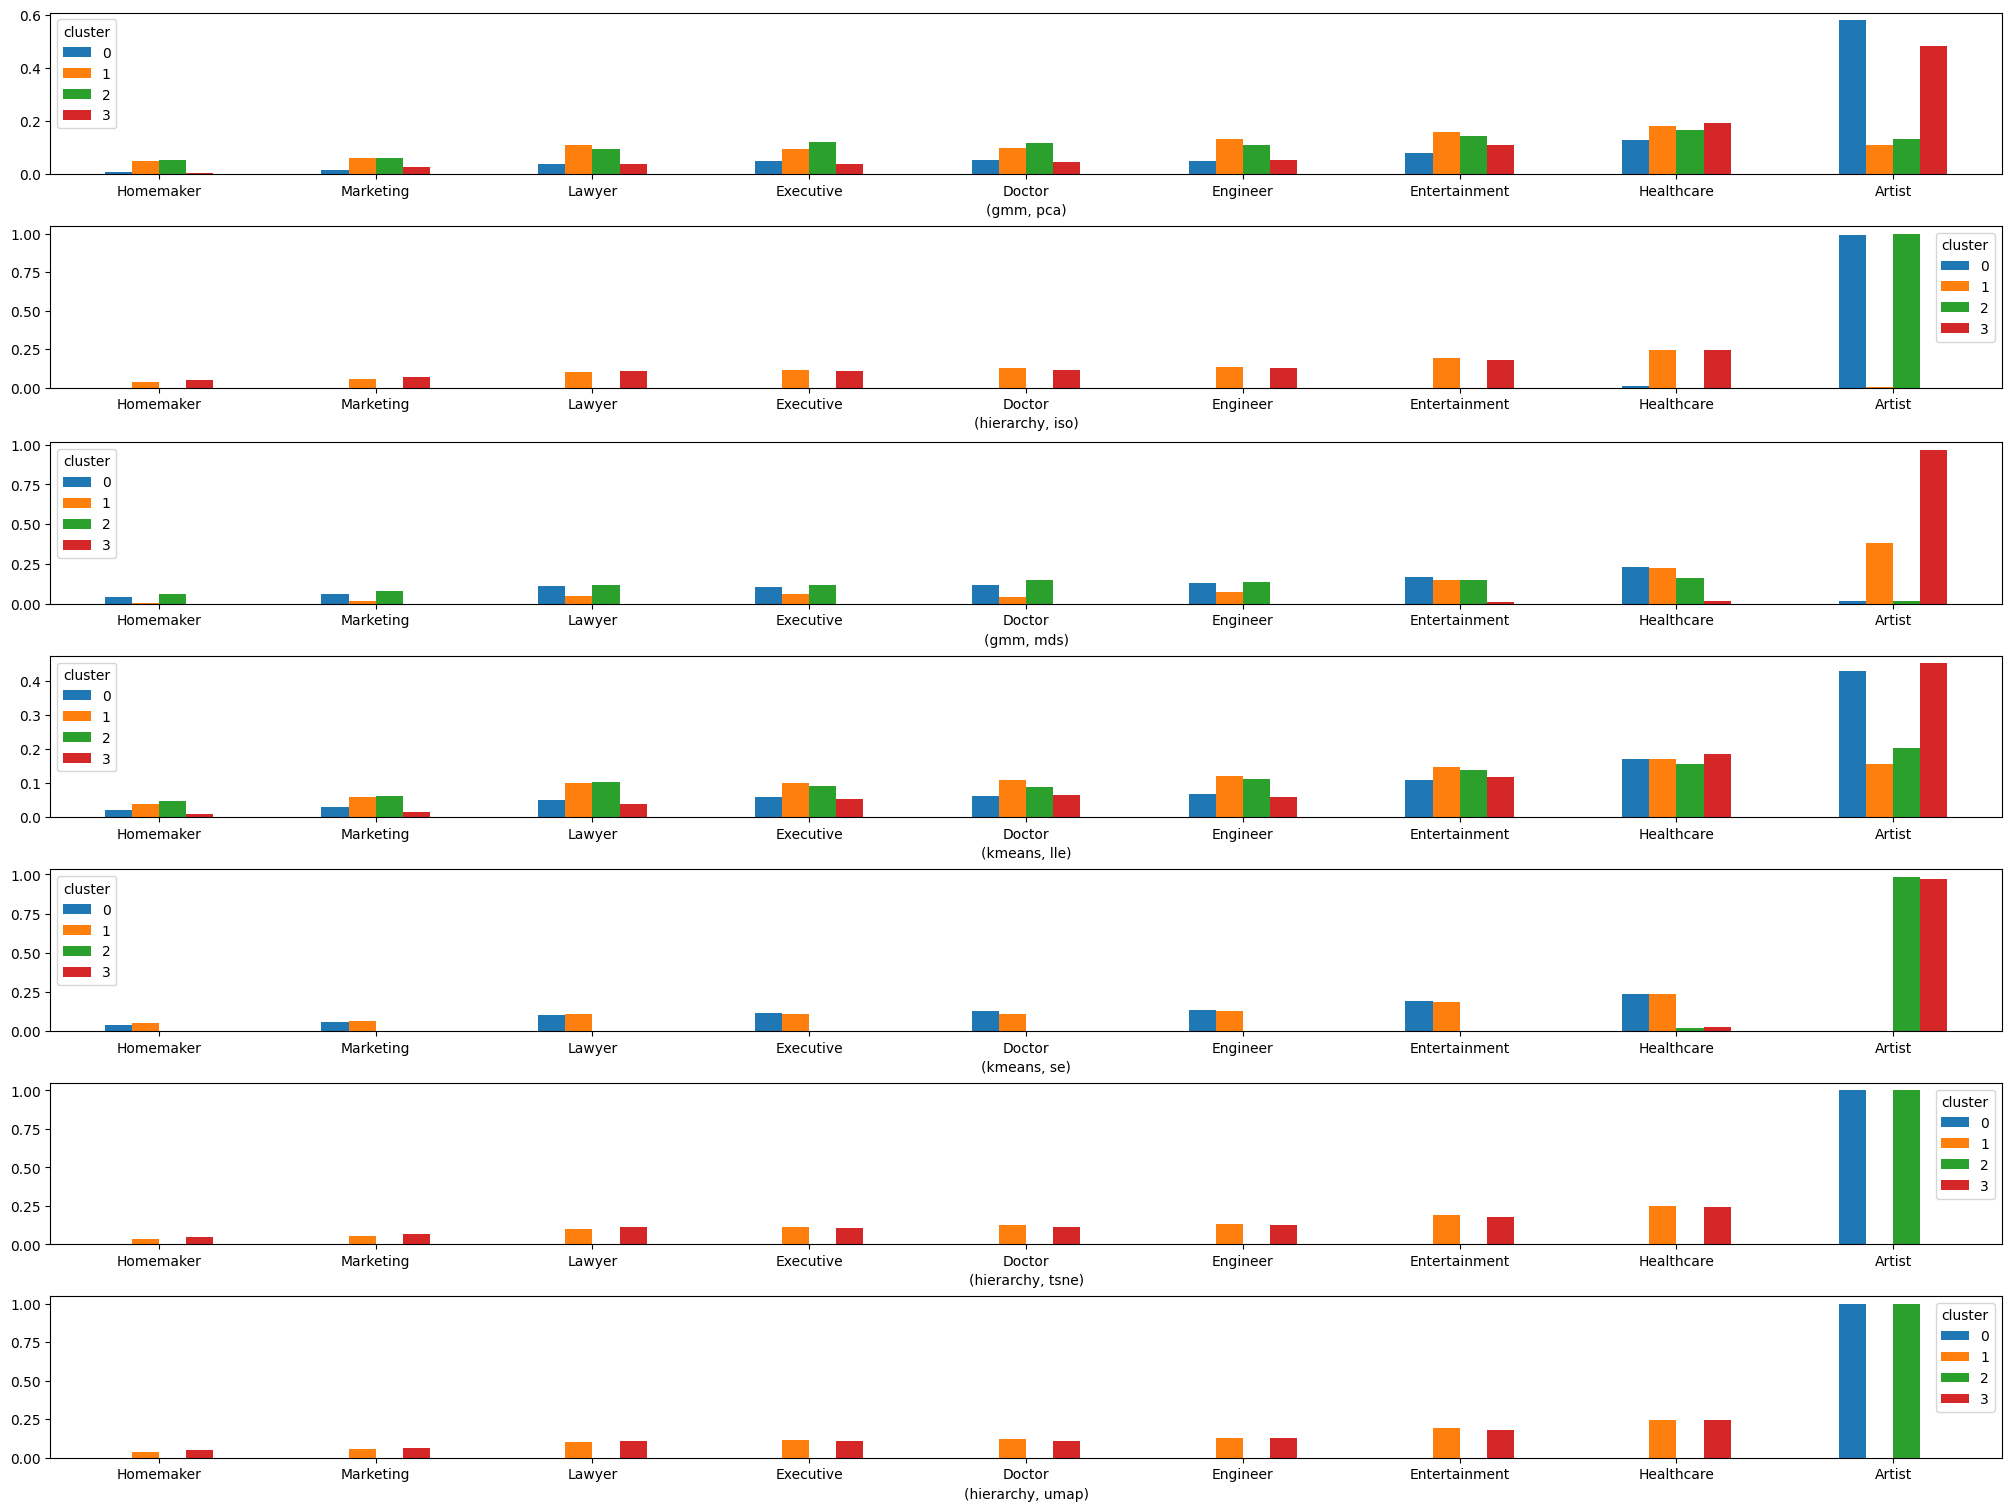

In [51]:
# profession

fig, ax = plt.subplots(7, 1, figsize=(20,15), layout='constrained')
for i, cluster in enumerate(clusters):
    df_04 = (df_c.groupby(cluster)['profession'].value_counts()\
        / df_c.groupby(cluster)['profession'].count()).unstack()
    df_04 = pd.DataFrame(df_04.values,
                         columns=[dic_decode2[df_04.columns[0]],
                                  dic_decode2[df_04.columns[1]],
                                  dic_decode2[df_04.columns[2]],
                                  dic_decode2[df_04.columns[3]],
                                  dic_decode2[df_04.columns[4]],
                                  dic_decode2[df_04.columns[5]],
                                  dic_decode2[df_04.columns[6]],
                                  dic_decode2[df_04.columns[7]],
                                  dic_decode2[df_04.columns[8]]],
                         index=[0, 1, 2, 3])
    df_04.index.name = 'cluster'
    df_04.columns.name = cluster
    df_04.T.plot(kind='bar', ax=ax[i])
    ax[i].tick_params(axis='x', rotation=0)
    display(df_04.T)
plt.show()

# Artistが突出していることからArtistとそれ以外で分割するものが多い
# 結果、2×2=4分割としているもののスコアが高いのはそういうデータ仕様だから仕方がない

,work_experience,spending_score,annual_income,age
"(gmm, pca)",,,,
0,-0.475,0.500,-0.704,-0.440
1,-0.244,-0.646,-0.480,0.229
2,0.539,-0.330,0.747,0.413
3,0.221,0.655,0.518,-0.273


,work_experience,spending_score,annual_income,age
"(hierarchy, iso)",,,,
0,0.029,0.088,0.006,-0.029
1,0.023,-0.037,0.006,0.022
2,0.029,0.032,-0.056,0.007
3,-0.040,-0.015,0.021,-0.010


,work_experience,spending_score,annual_income,age
"(gmm, mds)",,,,
0,-0.177,-0.216,-0.702,-0.192
1,0.101,0.302,0.602,0.273
2,0.263,-0.226,0.490,0.029
3,-0.173,0.187,-0.306,-0.098


,work_experience,spending_score,annual_income,age
"(kmeans, lle)",,,,
0,0.053,0.071,0.484,0.046
1,-0.024,-0.102,-0.457,0.018
2,-0.159,-0.070,-0.564,-0.052
3,0.168,0.102,0.544,-0.022


,work_experience,spending_score,annual_income,age
"(kmeans, se)",,,,
0,0.023,-0.057,0.030,0.023
1,-0.032,-0.019,0.030,-0.005
2,0.013,0.040,-0.072,-0.005
3,0.029,0.132,-0.051,-0.031


,work_experience,spending_score,annual_income,age
"(hierarchy, tsne)",,,,
0,0.041,0.104,-0.015,-0.007
1,0.018,-0.043,0.014,0.013
2,0.029,0.032,-0.056,0.007
3,-0.040,-0.015,0.021,-0.010


,work_experience,spending_score,annual_income,age
"(hierarchy, umap)",,,,
0,0.041,0.104,-0.015,-0.007
1,0.018,-0.043,0.014,0.013
2,0.029,0.032,-0.056,0.007
3,-0.040,-0.015,0.021,-0.010


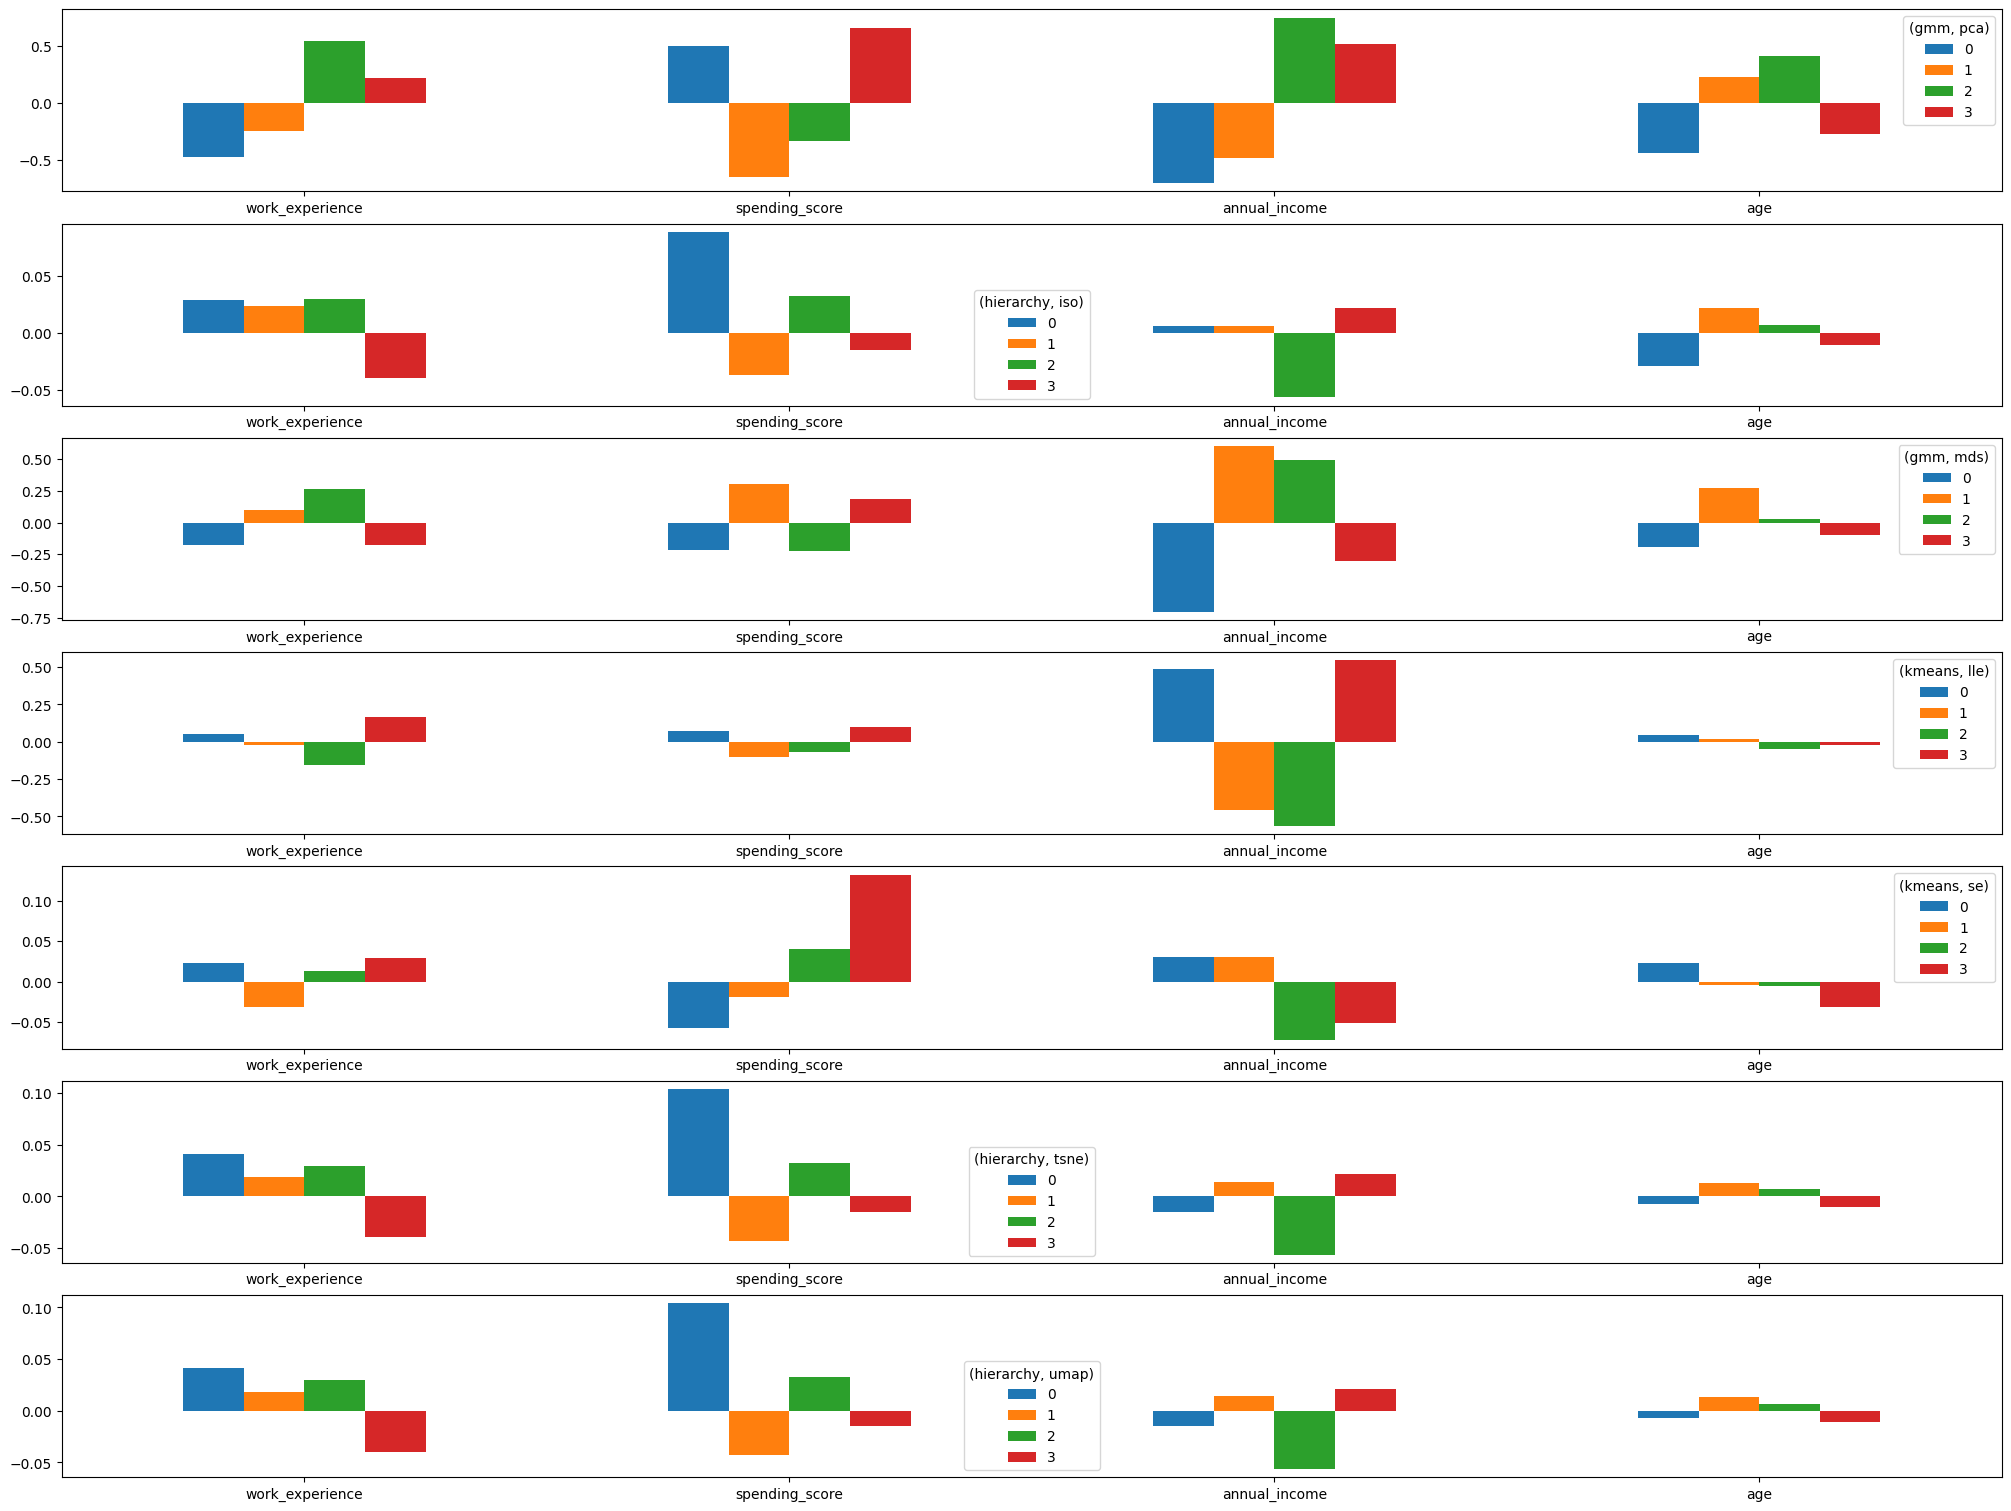

In [52]:
# work_experience, spending_score, annual_income, age

fig, ax = plt.subplots(7, 1, figsize=(20,15), layout='constrained')
for i, cluster in enumerate(clusters):
    df_02 = df_c.groupby(cluster).agg({'work_experience':'mean',
                                   'spending_score':'mean',
                                   'annual_income':'mean',
                                   'age':'mean'})
    df_02.T.plot(kind='bar', ax=ax[i])
    ax[i].tick_params(axis='x', rotation=0)
    display(df_02)
plt.show()

# gender, profession以外はモデルにより分割の仕方は様々なのでそこで解釈する


## クラスタリングの解釈

1. カウントエンコーディング実施時のkmeans（hierarcheyも同じ）,umapの分類
* 男性Artist,女性Artist,男性その他、女性その他の２×２で完全に説明されている
```
  * クラスタリングのスコアは非常に高い
  * 消費性向は、男性Artist、女性Artist、女性その他、男性その他の順
  * 年収は、女性その他、男性その他、男性Artist、女性Artistの順
  * 職歴は男性Artist、女性Artist、男性その他、女性その他の順
  * 年齢の違いは僅少
  * 総じてArtistは収入がないわりに職歴は長く金払いが良いという結果
  * 但し、これは機械でやらなくてもEDAで再現できる
    (つまり、カウントエンコーディングを選択した時点である程度予測できる)
```

2. ラベルエンコーディング実施時のhierarchy,isoの分類
```
  * クラスタリングスコアは並み
  * 男性、女性の別のほか職業は比較的フラットな分類
  * 消費性向、年収、職歴、年齢が、各クラスどれも同様の傾向
  * つまり、各量的特徴量の平均が大きい順に並び、うち2つが男性で2つが女性
  * 解釈的には分かりやすいもののひとつかもしれない
  * 全般に概ね程度の甚だしい方から順に4段階ということ
```

3. 標準化なし、ラベルエンコーディング、gmm,pcaの分類
```
  * クラスタリングスコアは並み
  * 各グループの数が比較的均等
  * 消費性向1位、年齢2位、職歴2位、年収2位、entertainment1位のグループ
  * 消費性向3位、年齢4位、職歴4位、年収4位､ Artist1位のグループ
  * 消費性向2位、年齢3位、職歴1位、年収1位､ Doctor1位のグループ
  * 消費性向4位、年齢1位、職歴3位、年収3位､ Healthcare1位のグループ
  * これは解釈の自由度が高い（なんとでも言える）
```